![heading.png](heading.png)

# Executive Summary

Pokémon is a video game franchise that has existed for more than two decades now. Today, there are more than 800 Pokemon and 18 different Pokémon types, spanning 7 generations. With each new generation, dozens of Pokemons are introduced, with varying types, making it a problem for those without Pokemon knowledge to follow the franchise. As such, a machine learning approach is taken to identify a Pokemon's type, given its image.

The data consists of 120 by 120 px images of the 809 Pokemon currently introduced. Each image is processed in order to extract features containing its color and size information. In doing so, we minimize the features from 43200 features to 21. Aside from the images, there is also data on the names and their respective types, which we use as targets.

The analysis is done twice: one for the original data, and another undersampled to balance the data. Logistic Regression with L1 regularization is used for the original data while Linear SVM with L1 regularization is used for the balanced data due to having the highest accuracy. From the resulting models, the predictability of different Pokemon types and generations are observed.

From this analysis, we observe that different combination of features lead to different accuracies, and more features does not necessarily lead to higher accuracy since some features introduce noise. 

The overall accuracy of the models are not worth mentioning as they range from 10% to 40% but breaking these down to the respective classes will yield accuracies ranging from 0% to 80%. This indicates that the features designed are predictive of some classes but not all.

The analysis done in this project is only applied to Pokemon data but it can be applied to other datasets. The ideas and learnings obtained from this project can be useful for analysis and other machine learning problems to be encountered in the future.


# Table of Contents
1. <a href='#introduction'>Introduction</a>
2. <a href='#data'>Data Description</a>
3. <a href='#eda'>EDA and Feature Extraction</a><br>
    3a. <a href='#color'>Color features</a><br>
    3b. <a href='#size'>Size features</a>
4. <a href='#imbalanced'>Classification using imbalanced dataset</a><br>
    4a. <a href='#imb-main'>Main type as target</a><br>
    4b. <a href='#imb-sec'>Secondary type as target</a><br>
    4c. <a href='#imb-sum'>Summary (Imbalanced)</a>
5. <a href='#balanced'>Data balancing through undersampling</a><br>
    5a. <a href='#bal-main'>Main type as target</a><br>
    5b. <a href='#bal-sec'>Secondary type as target</a><br>
    5c. <a href='#bal-sum'>Summary (Balanced)</a>
6. <a href='#conclusion'>Conclusion and insights</a><br>
<a href='#ref'>References</a><br>
<a href='#ack'>Acknowledgements</a><br>
<a href='#appendix'>Appendix</a><br>


In [222]:

from IPython.display import HTML

HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')


<a id="introduction"></a>
# Introduction

**Pokémon**, short for Pocket Monsters, is a video game franchise created in 1995 but is still releasing versions up until today, with an upcoming version set to release November this year. With Pokémon expanding to other media like movies and mobile apps, it has reached the global market, even capturing those who are not the main followers of the franchise. For them, it is difficult to catch up to the system of Pokémon, particularly their type system.

The type of some Pokémon can easily be identified based on their color schemes, red for fire, blue for water, green for grass, and the like. However, this is not true for all and so, other information like the presence of wings, size of the Pokemon, and the like, must also be extracted.

Most image recognition processes are done through deep learning or by using the pixels of the images as features. However, processing this type of data can be computationally heavy due to the sheer number of features ($\text{Image Dimension} \times 3$). By reducing the number of features, we are also reducing the accuracy and the complexity at the same time, offering a cheaper way to classify images based on information like color theme and size information.

<a id="data"></a>
# Data Description
The dataset consists of images of 809 Pokemons (all the currently released Pokemons), downloaded from Kaggle. Each image depicts the Pokemon with a white background. There are two file types for the images, JPG and PNG, with the former for Pokemons in Gen VII while PNG is the format for the rest.

Aside from the images, a sheet containing the Pokemon names and their respective main and secondary types are also included in the dataset, ordered according to their National Pokedex number. To check the generation of the Pokemon, their Pokedex numbers are cross-referenced with Pokemon's wikipedia - bulbapedia.

There are 18 Pokemon types, any combination of which can give the Primary and Secondary type of a Pokemon. An important thing to note is that the 18 types were only completed in Gen VI. In Gen I, there are only 15 types, with Dark and Steel introduced in Gen II and Fairy introduced in Gen VI.

The csv file looks like this:

In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
import mglearn #library provided by amueller
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

C:\Users\Justin\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
C:\Users\Justin\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [3]:
df = pd.read_csv('pokemon.csv')
# df.drop('Reason for absence', axis=1, inplace=True)
df.head(10)

,Name,Type1,Type2
0,bulbasaur,Grass,Poison
1,ivysaur,Grass,Poison
2,venusaur,Grass,Poison
3,charmander,Fire,NaN
4,charmeleon,Fire,NaN
5,charizard,Fire,Flying
6,squirtle,Water,NaN
7,wartortle,Water,NaN
8,blastoise,Water,NaN
9,caterpie,Bug,NaN


<a id="eda"></a>
# EDA and Feature extraction

The pokemons are actually ordered by their (national) pokedex number, and so, we can get their Pokedex Number from the index. Using these Pokedex Numbers, we can infer their Generation:

In [4]:
df['Pokedex Number'] = df.index + 1
df.set_index('Pokedex Number', inplace=True)

In [5]:
df.loc[1:151, 'Generation'] = 1
df.loc[152:251, 'Generation'] = 2
df.loc[252:386, 'Generation'] = 3
df.loc[387:493, 'Generation'] = 4
df.loc[494:649, 'Generation'] = 5
df.loc[650:721, 'Generation'] = 6
df.loc[722:809, 'Generation'] = 7
df.sample(5)

,Name,Type1,Type2,Generation
Pokedex Number,,,,
24,arbok,Poison,NaN,1.0
658,greninja,Water,Dark,6.0
217,ursaring,Normal,NaN,2.0
153,bayleef,Grass,NaN,2.0
9,blastoise,Water,NaN,1.0


In [6]:
from PIL import Image


<a id="color"></a>

## Color feature
Possible features:

    - RGB channels histogram statistical values: mode, mean, stdev

### EDA

For the pokemon images, background is transparent for PNG files so using `im_arr.sum(axis=2)>0` is effective in order to filter the background. For JPG files, the background is white, but the edge is not clear, so we perform image processing techniques to generate the mask for JPG files

We look at the grayscale image first to filter out the edge:

#### PNG

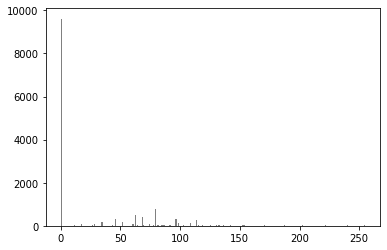

In [8]:
im = Image.open(f'images/zekrom.png').convert('LA')
im_arr = np.array(im)
fig, ax = plt.subplots()
ax.hist(im_arr[im_arr.mean(axis=2)<254,0], color='gray', bins=255);
# ax[2].hist(im_arr[im_arr.mean(axis=2)<255,2], color='b')


Looking at the very high count for grayscale value of EXACTLY 0, we don't need to do any thresholding to remove the background.

#### JPG

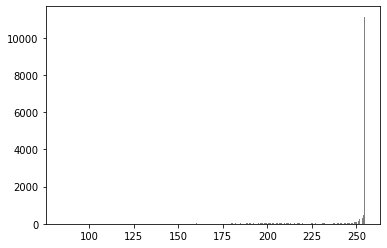

In [9]:
im = Image.open(f'images/brionne.jpg').convert('LA')
im_arr = np.array(im)[:,:,0]
fig, ax = plt.subplots()
ax.hist(im_arr.flatten(), color='gray', bins=255);
# ax[2].hist(im_arr[im_arr.mean(axis=2)<255,2], color='b')


The white background corresponds to the grayscale value of 255. We can check if we can completely remove the background by filtering the 255 values:


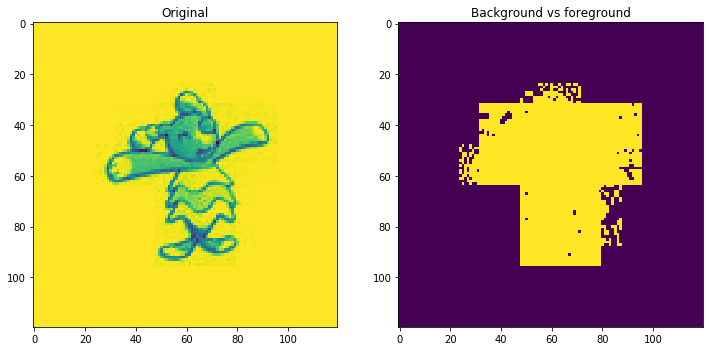

In [10]:
fig,ax = plt.subplots(1,2, figsize=(12,8))
ax[0].imshow(im_arr, interpolation=None)
ax[0].set_title('Original')
ax[1].set_title('Background vs foreground')
ax[1].imshow(im_arr<255)

However, when the pixels transition from background to foreground, there is an interpolation of colors, making it more difficult to filter the background. We can threshold the background instead:

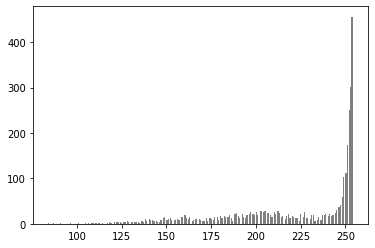

In [11]:
im = Image.open(f'images/brionne.jpg').convert('LA')
im_arr = np.array(im)[:,:,0]
fig, ax = plt.subplots()
ax.hist(im_arr[im_arr!=255], color='gray', bins=255);
# ax[2].hist(im_arr[im_arr.mean(axis=2)<255,2], color='b')


From the histogram, an appropriate threshold would be chosen by tweaking the parameters for the most difficult image to process: brionne (which is a pokemon that has alot of white elements)

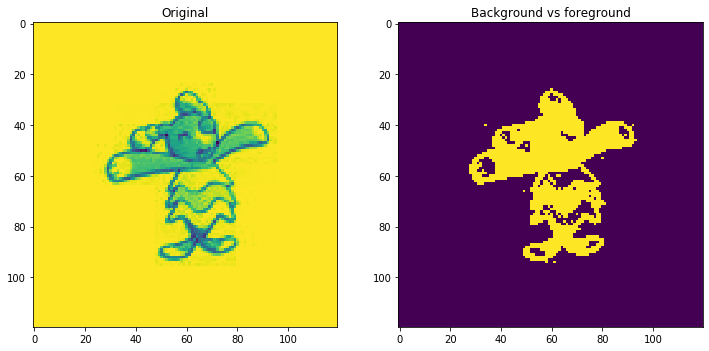

In [12]:
fig,ax = plt.subplots(1,2, figsize=(12,8))
ax[0].imshow(im_arr, interpolation=None)
ax[0].set_title('Original')
ax[1].set_title('Background vs foreground')
ax[1].imshow(im_arr<245)

which is better. But it leaves spaces in the foreground.

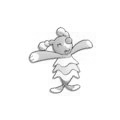

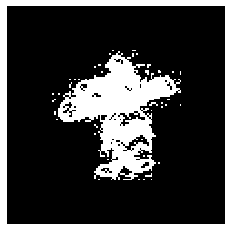

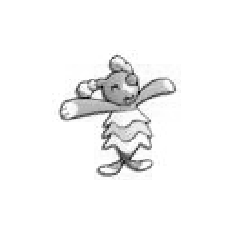

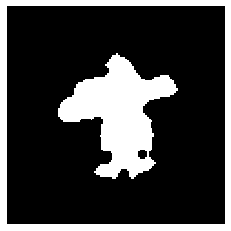

<Figure size 432x288 with 0 Axes>

In [13]:
from skimage.morphology import binary_closing, binary_opening
plt.figure()
plt.imshow(im_arr<251, cmap='gray')
plt.axis('off')
# plt.savefig('threshold.png', dpi=300, bbox_inches='tight')
plt.figure()
plt.imshow(im_arr, cmap='gray')
plt.axis('off')
# plt.savefig('orig.png', dpi=300, bbox_inches='tight')
plt.figure()
neighborhood = np.ones((5,5))
neighborhood[0, 0] = 0
neighborhood[0, -1] = 0
neighborhood[-1, 0] = 0
neighborhood[-1, -1] = 0
mask = binary_closing(binary_opening(im_arr<251), neighborhood)
plt.imshow(mask, cmap='gray')
plt.axis('off')
# plt.savefig('processed.png', dpi=300, bbox_inches='tight')
plt.figure()
im

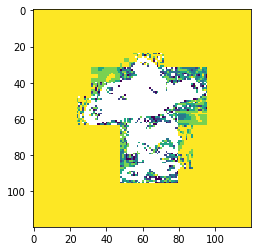

In [14]:
plt.imshow(np.ma.masked_array(im_arr[:,:], (im_arr<250)), interpolation=None)

In [15]:
from scipy import stats

For each color channel, we extract the following information:
- mean
- mode and the frequency at the mode
- standard deviation

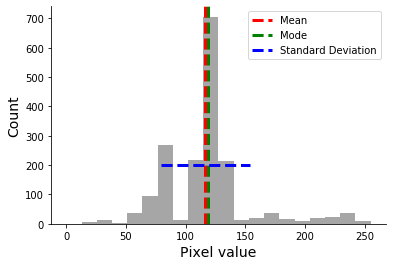

In [16]:
im = Image.open(f'images/pikachu.png').convert('RGBA')
im_arr = np.array(im)
fig, ax = plt.subplots()
ax.hist(im_arr[im_arr.sum(axis=2)>0,2], bins=20, color='gray', alpha=0.7)
ax.set_xlabel('Pixel value', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.axvline(im_arr[im_arr.sum(axis=2)>0, 2].mean(), color='red', ls='--', lw=3, label='Mean')
ax.axvline(stats.mode(im_arr[im_arr.sum(axis=2)>0, 2])[0][0], color='green', ls='--', lw=3, label='Mode')
ax.plot([im_arr[im_arr.sum(axis=2)>0, 2].mean() - im_arr[im_arr.sum(axis=2)>0, 2].std(),
          im_arr[im_arr.sum(axis=2)>0, 2].mean() + im_arr[im_arr.sum(axis=2)>0, 2].std()], [200, 200], 'b--', lw=3, label='Standard Deviation')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend()

In [17]:
from IPython.display import clear_output
def plot_pokemon(pokemon):
    im = Image.open(f'images/{pokemon}.PNG').convert('RGBA')
    im_arr = np.array(im)
    fig, ax = plt.subplots(1, 3, figsize=(16,4))
    ax[0].hist(im_arr[im_arr.sum(axis=2)>0,0], color='r',bins=15)
    ax[0].set_xlabel('Red Pixel Values')
    ax[0].spines['right'].set_visible(False)
    ax[0].spines['top'].set_visible(False)
    ax[0].set_ylabel('Count')
    ax[0].axis('off')
    ax[1].hist(im_arr[im_arr.sum(axis=2)>0,1], color='g',bins=15)
    ax[1].set_xlabel('Green Pixel Values')
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['top'].set_visible(False)
    ax[1].set_ylabel('Count')
    ax[1].axis('off')
    ax[2].hist(im_arr[im_arr.sum(axis=2)>0,2], color='b',bins=15)
    ax[2].set_xlabel('Blue Pixel Values')
    ax[2].spines['right'].set_visible(False)
    ax[2].spines['top'].set_visible(False)
    ax[2].set_ylabel('Count')
    ax[2].axis('off')
    ax[0].set_title(pokemon, loc='left', size=16)
    return im_arr, ax

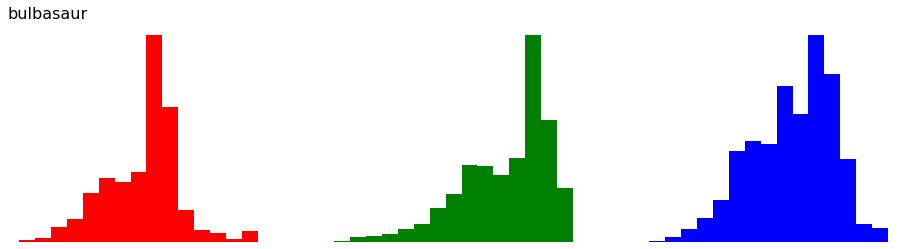

In [18]:
plot_pokemon('bulbasaur');

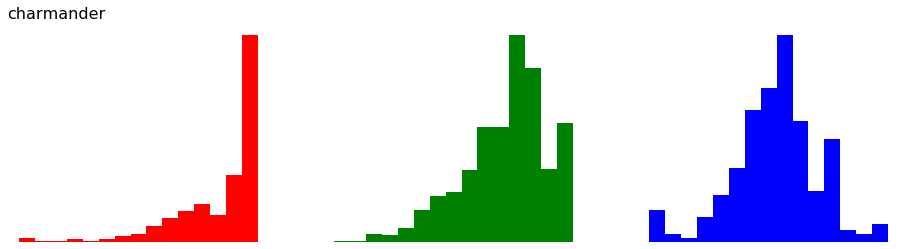

In [19]:
plot_pokemon('charmander');

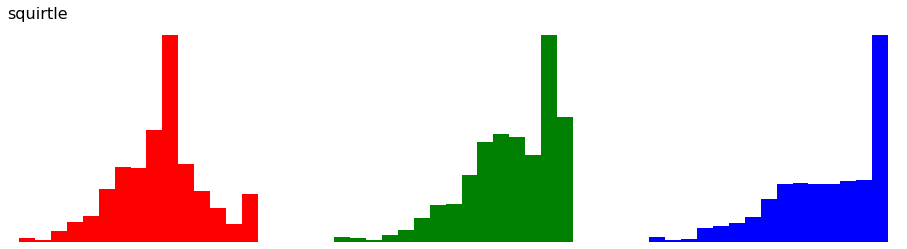

In [20]:
plot_pokemon('squirtle');

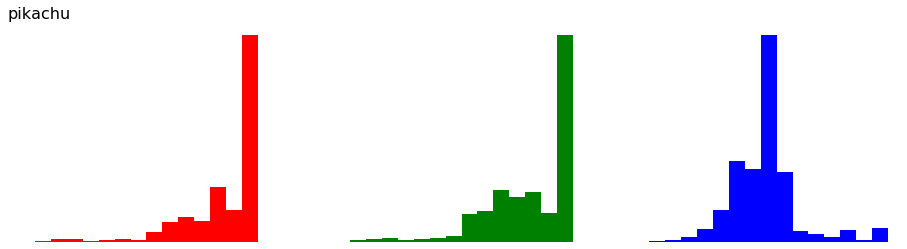

In [21]:
plot_pokemon('pikachu');

### Feature extraction

For this image, we will extract different features:

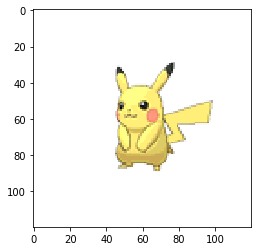

In [22]:
im = Image.open(f'images/pikachu.PNG').convert('RGBA')
im_arr = np.array(im)
im_arr_pokemon = im_arr[im_arr.sum(axis=2)>0]
plt.imshow(im_arr)

#### Mean <br>(red, green, blue)

In [23]:
def get_mean(im_arr_pokemon):
    mean_r = im_arr_pokemon[:, 0].mean()
    mean_g = im_arr_pokemon[:, 1].mean()
    mean_b = im_arr_pokemon[:, 2].mean()
    return (mean_r, mean_g, mean_b)
get_mean(im_arr_pokemon)

(220.36327458783398, 204.3939738487777, 116.59351904491189)

#### Mode and Mode Frequency <br>(mode_red, mode_green, mode_blue, frequency at mode_red, frequency at mode_green, frequency at mode_blue)

In [24]:
from scipy import stats

In [25]:
def get_mode_and_freq(im_arr_pokemon):
    mode_r = stats.mode(im_arr_pokemon[:, 0])[0][0]
    mode_g = stats.mode(im_arr_pokemon[:, 1])[0][0]
    mode_b = stats.mode(im_arr_pokemon[:, 2])[0][0]
    n_mode_r = (im_arr_pokemon[:, 0]==mode_r).sum() / len(im_arr_pokemon[:, 0])
    n_mode_g = (im_arr_pokemon[:, 1]==mode_g).sum() / len(im_arr_pokemon[:, 0])
    n_mode_b = (im_arr_pokemon[:, 2]==mode_b).sum() / len(im_arr_pokemon[:, 0])
    return (mode_r, mode_g, mode_b, n_mode_r, n_mode_g, n_mode_b)
get_mode_and_freq(im_arr_pokemon)

(255, 238, 119, 0.46219442865264354, 0.2984650369528141, 0.38828880045480385)

#### Standard deviation<br>(red, green, blue)

In [26]:
def get_std(im_arr_pokemon):
    std_r = im_arr_pokemon[:, 0].std()
    std_g = im_arr_pokemon[:, 1].std()
    std_b = im_arr_pokemon[:, 2].std()
    return (std_r, std_g, std_b)
get_std(im_arr_pokemon)

(45.50596652018251, 45.91241616382711, 37.047856871336265)

Now we extract the color features for all the Pokemon images.

In [28]:

import re
import os

files_ = next(os.walk('images'))[2]
png_or_jpg = dict(re.findall('(^.*)\.(.*$)', '\n'.join(files_), re.M))
df_feat_color = pd.DataFrame(columns=['mean_r', 'mean_g', 'mean_b', 'mode_r', 'mode_g', 'mode_b',
              'mode_freq_r', 'mode_freq_g', 'mode_freq_b', 'std_r', 'std_g',
               'std_b', 'png'], index=df.index)


neighborhood = np.ones((5,5))
neighborhood[0, 0] = 0
neighborhood[0, -1] = 0
neighborhood[-1, 0] = 0
neighborhood[-1, -1] = 0

for i in df.index:
    pokemon = df.loc[i].Name
    im = Image.open(f'images/{pokemon}.{png_or_jpg[pokemon]}').convert('RGBA')
    im_arr = np.array(im)
    if png_or_jpg[pokemon]=='png':
        mask = im_arr.sum(axis=2)>0
    elif png_or_jpg[pokemon]=='jpg':
        imgray = Image.open(f'images/{pokemon}.jpg').convert('LA')
        im_gray_arr = np.array(imgray)[:,:,0]
        mask = binary_closing(binary_opening(im_gray_arr<251), neighborhood)
    im_arr_pokemon = im_arr[mask]
    means = get_mean(im_arr_pokemon)
    modes = get_mode_and_freq(im_arr_pokemon)
    df_feat_color.loc[i] = [*means,
                            *modes,
                            *get_std(im_arr_pokemon),
                            png_or_jpg[pokemon]=='png'
                            ]
    

Checking the filetypes,

In [29]:
dummy = df_feat_color.copy()
dummy['Generation'] = df['Generation']

dummy.groupby('Generation')['png'].describe()

,count,unique,top,freq
Generation,,,,
1.0,151,1,True,151
2.0,100,1,True,100
3.0,135,1,True,135
4.0,107,1,True,107
5.0,156,1,True,156
6.0,72,1,True,72
7.0,88,1,False,88


Upon closer inspection, the images with PNG filetypes are those from Gen I to Gen VI pokemons while Gen VII pokemons have JPG filetypes.

In [30]:
df_feat_color.head()

,mean_r,mean_g,mean_b,mode_r,mode_g,mode_b,mode_freq_r,mode_freq_g,mode_freq_b,std_r,std_g,std_b,png
Pokedex Number,,,,,,,,,,,,,
1,141.361,192.116,161.39,153,221,187,0.295185,0.249128,0.179344,39.0903,47.1262,44.0586,True
2,144.255,155.1,161.621,136,119,136,0.180596,0.185879,0.15658,68.465,56.7961,59.4548,True
3,145.169,175.54,169.631,153,221,238,0.239791,0.175797,0.133466,50.8307,57.3943,65.4917,True
4,213.607,176.345,127.693,255,187,136,0.37781,0.188542,0.195069,49.409,45.0129,46.5492,True
5,218.464,151.415,123.425,255,153,136,0.410642,0.161943,0.149219,43.2752,50.9202,58.7825,True


After extracting the features, we look at the correlation matrix of these features

In [31]:
df_feat_color.columns

Index(['mean_r', 'mean_g', 'mean_b', 'mode_r', 'mode_g', 'mode_b',
       'mode_freq_r', 'mode_freq_g', 'mode_freq_b', 'std_r', 'std_g', 'std_b',
       'png'],
      dtype='object')

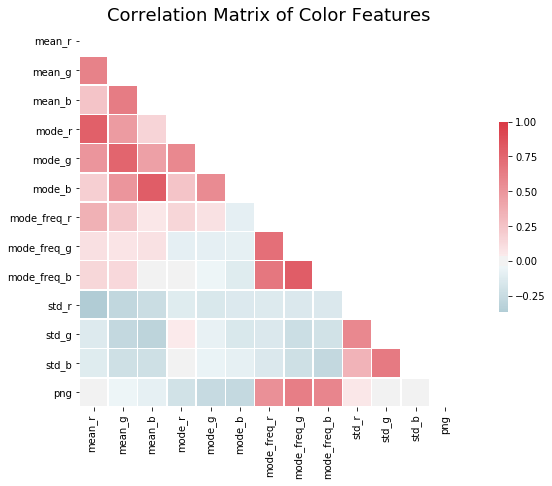

In [32]:
# Compute the correlation matrix
import seaborn as sns
df_feat_color = df_feat_color.astype(float)
corr = df_feat_color[df_feat_color.columns[:]].corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(14, 7))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});
ax.axes.set_title("Correlation Matrix of Color Features", fontsize=18, y=1.01);

Note that there are heavily correlated features like mean and mode of the respective channel, which is expected since there are many instances where the mean is very close to the mode. However, the fact that it is not always the same indicates that we can still use these separate features, since machine learning techniques have ways to deal with correlation (regularization).

What is unexpected here is the correlation of the RGB modes and the png to the modes. Note that the mode is very susceptible to improper foreground and background isolation. In the interest of time, we will employ the basic thresholding and morphological operations but we can make several recommendations to improve this result.

<a id="size"></a>
## Size feature

Aside from the colors, we can also extract the sizes through pixels since the images share the same dimensions (120 by 120). Though the sizes proportions among the pokemons are not exactly scaled appropriately, there is still a difference in the sizes, which we can use as features

### EDA
Comparing two Pokemons with significantly different size and shape,

In [59]:
im_large = Image.open('images/guzzlord.jpg').convert('RGBA')
im_arr_large = np.array(im_large)

imgray = Image.open(f'images/guzzlord.jpg').convert('LA')
im_gray_arr = np.array(imgray)[:,:,0]
mask_large = binary_closing(binary_opening(im_gray_arr<251), neighborhood)

im_small = Image.open('images/wingull.png').convert('RGBA')
im_arr_small = np.array(im_small)
mask_small = im_arr_small.sum(axis=2)>0

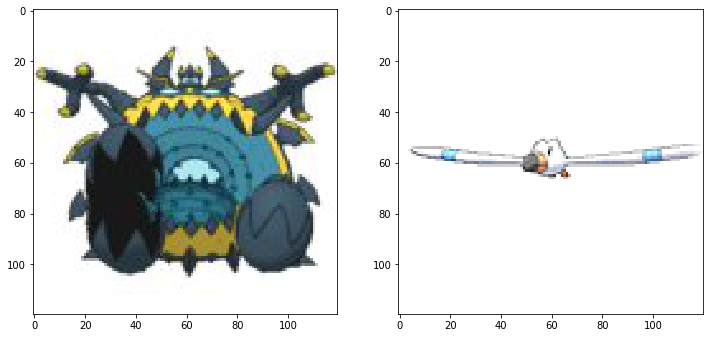

In [60]:
fig, ax = plt.subplots(1,2,figsize=(12,7))
ax[0].imshow(im_arr_large)
ax[1].imshow(im_arr_small)

However, as expected, while guzzlord (left) is larger than wingull (right), it is not to scale since guzzlord (according to wiki) is 5.5m tall while anorith is 0.61m. Nonetheless, we will use the pixels as proxies.

Foreground

(-0.5, 119.5, 119.5, -0.5)

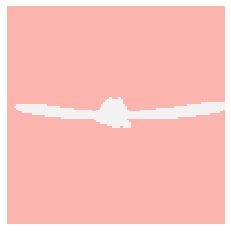

In [61]:
plt.imshow(mask_small, cmap='Pastel1')
plt.axis('off')

Background

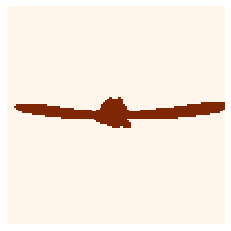

In [62]:
plt.imshow(mask_small, cmap='Oranges')
plt.axis('off')
# plt.savefig('foreground.png', dpi=300, bbox_inches='tight')

In [63]:
from matplotlib import cm

Nonetheless, there are still observable differences which is why it may be necessary to extract information like height and width information.

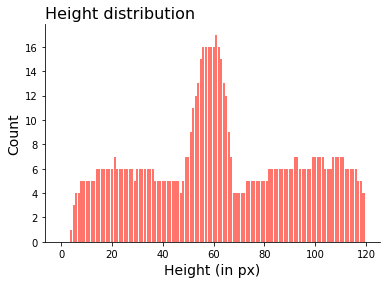

In [75]:
fig, ax = plt.subplots()
ax.bar(range(120),(mask_small).sum(axis=0), color=(0.9998769703960015, 0.4589388696655133, 0.4180007689350249, 1.0)) #height
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Height (in px)', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.set_title('Height distribution', loc='left', size=16);
# ax.axis('off');

Text(0.0, 1.0, 'Height distribution')

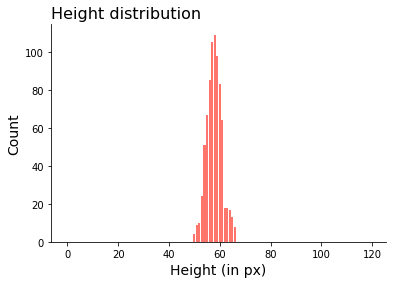

In [73]:
fig, ax = plt.subplots()
ax.bar(range(120),(mask_small).sum(axis=1), color=(0.9998769703960015, 0.4589388696655133, 0.4180007689350249, 1.0)) #height
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Height (in px)', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.set_title('Height distribution', loc='left', size=16);
# ax.axis('off');

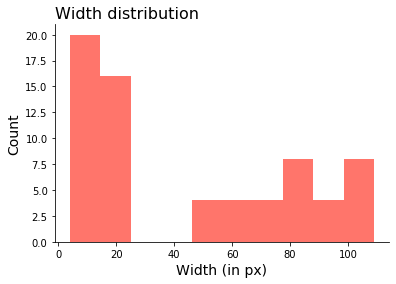

In [74]:
fig, ax = plt.subplots()
ax.hist((im_arr_small>0).sum(axis=1)[(im_arr_small>0).sum(axis=1)>0], color=(0.9998769703960015, 0.4589388696655133, 0.4180007689350249, 1.0)) #height
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Width (in px)', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.set_title('Width distribution', loc='left', size=16);
# ax.axis('off')

### Feature extraction

For the two Pokemons (Guzzlord and Wingull), we extract the following features:

#### Size

Guzzlord

In [76]:
mask_large.sum()

7413

Wingull

In [77]:
mask_small.sum()

783

#### Height

In [78]:
def height_info(mask):
    height = mask.sum(axis=0)[mask.sum(axis=0)>0]
    return (np.mean(height), stats.mode(height)[0][0], np.std(height))

Wingull (mean, mode, standard deviation)

In [79]:
height_info(mask_small)

(6.75, 6, 3.142794166408897)

Guzzlord (mean, mode, standard deviation)

In [80]:
height_info(mask_large)

(61.775, 74, 27.09257662780219)

#### Width

In [81]:
def width_info(mask):
    width = mask.sum(axis=1)[mask.sum(axis=1)>0]
    return (np.mean(width), stats.mode(width)[0][0], np.std(width))

Wingull (mean, mode, standard deviation)

In [82]:
width_info(mask_small)

(46.05882352941177, 18, 37.329172613757216)

Guzzlord (mean, mode, standard deviation)

In [83]:
width_info(mask_large)

(80.57608695652173, 91, 25.38624828680668)

Now we extract the size features from the Pokemon images

In [85]:
files_ = next(os.walk('images'))[2]
png_or_jpg = dict(re.findall('(^.*)\.(.*$)', '\n'.join(files_), re.M))

df_feat_size = pd.DataFrame(columns=['size', 'mean_width', 'mode_width', 'std_width',
                                    'mean_length', 'mode_length', 'std_length'], index=df.index)


neighborhood = np.ones((5,5))
neighborhood[0, 0] = 0
neighborhood[0, -1] = 0
neighborhood[-1, 0] = 0
neighborhood[-1, -1] = 0

for i in df.index:
    pokemon = df.loc[i].Name
    im = Image.open(f'images/{pokemon}.{png_or_jpg[pokemon]}').convert('RGBA')
    im_arr = np.array(im)
    if png_or_jpg[pokemon]=='png':
        mask = im_arr.sum(axis=2)>0
    elif png_or_jpg[pokemon]=='jpg':
        imgray = Image.open(f'images/{pokemon}.jpg').convert('LA')
        im_gray_arr = np.array(imgray)[:,:,0]
        mask = binary_closing(binary_opening(im_gray_arr<251), neighborhood)
    size = mask.sum()
    df_feat_size.loc[i] = [size,
                           *width_info(mask),
                           *height_info(mask)]

In [86]:
df_feat_size.head()

,size,mean_width,mode_width,std_width,mean_length,mode_length,std_length
Pokedex Number,,,,,,,
1,1433,31.1522,38,10.8907,34.119,38,10.2544
2,2082,33.5806,39,12.9758,28.1351,3,23.234
3,4016,57.3714,75,20.7269,42.2737,63,20.9226
4,1379,24.625,26,6.99888,33.6341,51,19.2389
5,1729,27.0156,27,10.2416,37.587,57,18.169


## Combine!

In [87]:
df_feat = df_feat_color.join(df_feat_size)
df_feat['Generation'] = df['Generation']

In [88]:
df_feat.head()

,mean_r,mean_g,mean_b,mode_r,mode_g,mode_b,mode_freq_r,mode_freq_g,mode_freq_b,std_r,...,std_b,png,size,mean_width,mode_width,std_width,mean_length,mode_length,std_length,Generation
Pokedex Number,,,,,,,,,,,,,,,,,,,,,
1,141.361479,192.115841,161.390091,153.0,221.0,187.0,0.295185,0.249128,0.179344,39.090272,...,44.058603,1.0,1433,31.1522,38,10.8907,34.119,38,10.2544,1.0
2,144.254563,155.099904,161.620557,136.0,119.0,136.0,0.180596,0.185879,0.156580,68.464976,...,59.454752,1.0,2082,33.5806,39,12.9758,28.1351,3,23.234,1.0
3,145.169074,175.539841,169.630976,153.0,221.0,238.0,0.239791,0.175797,0.133466,50.830729,...,65.491676,1.0,4016,57.3714,75,20.7269,42.2737,63,20.9226,1.0
4,213.606962,176.345178,127.692531,255.0,187.0,136.0,0.377810,0.188542,0.195069,49.409046,...,46.549167,1.0,1379,24.625,26,6.99888,33.6341,51,19.2389,1.0
5,218.464430,151.414691,123.424523,255.0,153.0,136.0,0.410642,0.161943,0.149219,43.275183,...,58.782531,1.0,1729,27.0156,27,10.2416,37.587,57,18.169,1.0


<a id="imbalanced"></a>

# Classification using imbalanced dataset
Targets:
1. Primary type only
2. Secondary type only

It is possible to predict the combination of both but that would lead to more classes, making the problem more difficult.

<a id="imb-main"></a>

### Primary Type only

In [89]:
df_target_A = df['Type1']

Text(0.5, 0, 'Count')

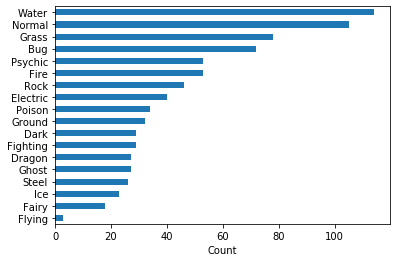

In [90]:
df_target_A.value_counts()[::-1].plot.barh()
plt.xlabel('Count')

Looking at the distribution of the target classes, it is immediately obvious that the dataset is imbalanced. Particularly with Flying Pokemons, this type is usually a Secondary Type rather than a Primary Type, causing it to have a low count. Nonetheless, we will continue with this data and observe the results.


For this analysis, we use three combinations of features:
1. All the features
2. Only the color features
3. Only the size features

in order to predict the primary type of the Pokemon

#### Combined features


In [91]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from warnings import filterwarnings
filterwarnings('ignore')

import importlib

from sklearn import model_selection, preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier


In [92]:
print(f'1.25 x PCC = {125*((df_target_A.value_counts() / df_target_A.count())**2).sum():.2f}%')

1.25 x PCC = 9.83%


In [93]:
cl1 = KNeighborsClassifier(n_jobs=-1)
cl2 = LogisticRegression(penalty='l1', max_iter=1000,
                         solver='liblinear', n_jobs=-1)
cl3 = LogisticRegression(penalty='l2', max_iter=1000, n_jobs=-1)
cl4 = LinearSVC(penalty='l1', dual=False, max_iter=10000)
cl5 = LinearSVC(penalty='l2', max_iter=10000)
cl6 = SVC(kernel='rbf', )
cl7 = SVC(kernel='poly', degree=3)
cl8 = DecisionTreeClassifier()
cl9 = RandomForestClassifier(max_features='sqrt')
cl10 = GradientBoostingClassifier()
kneighbors = range(1, 31)
C_list = np.logspace(-5, 5, num=10)
gamma_list = np.logspace(-5, 5, num=10)

estimators = [('KNN', cl1, {'n_neighbors':kneighbors}),
              ('Logistic Regression (L1)', cl2, {'C':C_list}),
              ('Logistic Regression (L2)', cl3, {'C':C_list}),
              ('Linear SVM (L1)', cl4, {'C':C_list}),
              ('Linear SVM (L2)', cl5, {'C':C_list}),
              ('NonLinear SVM (RBF)', cl6, {'C':C_list,
                                            'gamma':gamma_list}),
              ('NonLinear SVM (Poly)', cl7, {'C':C_list,
                                             'gamma':gamma_list}),
              ('Decision Tree', cl8, {'max_depth':range(1,11),
                                      'criterion':['gini', 'entropy']}),
              ('Random Forest', cl9, {'max_depth':range(1,4),
                                      'n_estimators':range(10,101,10),
                                      'criterion':['gini', 'entropy']}),
              ('GBM', cl10, {'max_depth':range(1,4),
                            'n_estimators':range(10,101,10),
                            'learning_rate':np.arange(0.1,1.01,0.1)})]

In [94]:
X = df_feat.astype(float)
y = df_target_A

X_train, X_val, y_train, y_val = model_selection.train_test_split(X, y,
                                                            random_state=1)
scaler = preprocessing.RobustScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [96]:
models = {}
for est in estimators:
    print(f'Training {est}\n')
    gs_cv = model_selection.GridSearchCV(est[1], param_grid=est[2], n_jobs=4)
    gs_cv.fit(X_train, y_train)
    models[est[0]] = gs_cv

Training ('KNN', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform'), {'n_neighbors': range(1, 31)})

Training ('Logistic Regression (L1)', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=-1, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False), {'C': array([1.00000000e-05, 1.29154967e-04, 1.66810054e-03, 2.15443469e-02,
       2.78255940e-01, 3.59381366e+00, 4.64158883e+01, 5.99484250e+02,
       7.74263683e+03, 1.00000000e+05])})

Training ('Logistic Regression (L2)', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   mu

In [97]:
cols = ['Machine Learning Method', 'Test Accuracy',
        'Best Parameter', 'Top Predictor Variable']
df_acc_prim_all = pd.DataFrame(columns=cols)

for i, m in enumerate(models):
    
    try:
        top_predictor = X.columns[
            np.argmax(np.abs(models[m].best_estimator_.coef_).mean(axis=0))]

    except AttributeError:
        top_predictor = np.nan
    
    df_acc_prim_all.loc[i] = [m, 
                 models[m].best_estimator_.score(X_val, y_val),
                 models[m].best_params_ ,
                 top_predictor]

In [98]:
df_acc_prim_all

,Machine Learning Method,Test Accuracy,Best Parameter,Top Predictor Variable
0,KNN,0.206897,{'n_neighbors': 23},NaN
1,Logistic Regression (L1),0.261084,{'C': 3.593813663804626},png
2,Logistic Regression (L2),0.231527,{'C': 3.593813663804626},png
3,Linear SVM (L1),0.290640,{'C': 0.2782559402207126},mean_b
4,Linear SVM (L2),0.280788,{'C': 0.2782559402207126},png
5,NonLinear SVM (RBF),0.275862,"{'C': 46.41588833612782, 'gamma': 0.0016681005...",NaN
6,NonLinear SVM (Poly),0.211823,"{'C': 0.0001291549665014884, 'gamma': 3.593813...",NaN
7,Decision Tree,0.197044,"{'criterion': 'gini', 'max_depth': 5}",NaN
8,Random Forest,0.226601,"{'criterion': 'gini', 'max_depth': 3, 'n_estim...",NaN
9,GBM,0.206897,"{'learning_rate': 0.2, 'max_depth': 1, 'n_esti...",NaN


From the different models, Logistic Regression with L1 regularization is the best. Looking at the weights:

(-0.6919057517439353, 0.6919057517439353)

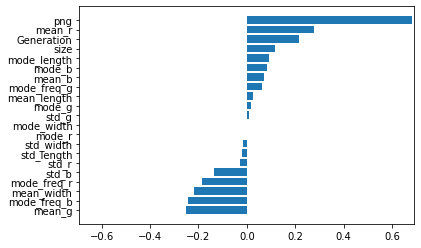

In [99]:
coefs = models['Logistic Regression (L1)'].best_estimator_.coef_.mean(axis=0)
plt.barh(df_feat.columns[np.argsort(coefs)], np.sort(coefs))
plt.xlim(-max(abs(coefs)) -0.01, max(abs(coefs))+0.01)

In [100]:
cols = ['Machine Learning Method', 'Test Accuracy',
        'Best Parameter', 'Top Predictor Variable']
df_acc_prim_all_types = pd.DataFrame(columns=cols)

# for i, m in enumerate(models):
m = 'Logistic Regression (L1)'
for i in df_target_A.value_counts().index[::-1]:
    try:
        top_predictor = dict(zip(X.columns, np.abs(models[m].best_estimator_.coef_).mean(axis=0)))

    except AttributeError:
        top_predictor = np.nan
    
    df_acc_prim_all_types.loc[i] = [m, 
                 models[m].best_estimator_.score(X_val[y_val==i], y_val[y_val==i]),
                 models[m].best_params_ ,
                 top_predictor]

Looking at the accuracies for the different classifications:

In [101]:
df_acc_prim_all_types[['Test Accuracy']]

,Test Accuracy
Flying,0.000000
Fairy,0.200000
Ice,0.285714
Steel,0.000000
Ghost,0.333333
Dragon,0.000000
Fighting,0.000000
Dark,0.400000
Ground,0.000000
Poison,0.333333


In [102]:
cols = ['Machine Learning Method', 'Test Accuracy',
        'Best Parameter', 'Top Predictor Variable']
df_acc_prim_all_gen = pd.DataFrame(columns=cols)
gen_scaled = dict(zip(range(1, 8), np.unique(X_val[:, -1])))

# for i, m in enumerate(models):
m = 'Logistic Regression (L1)'

for i in range(1,8):
    try:
        top_predictor = dict(zip(X.columns, np.abs(models[m].best_estimator_.coef_).mean(axis=0)))

    except AttributeError:
        top_predictor = np.nan
    
    df_acc_prim_all_gen.loc[i] = [m, 
                     models[m].best_estimator_.score(X_val[X_val[:, -1]==gen_scaled[i]], y_val[X_val[:, -1]==gen_scaled[i]]),
                     models[m].best_params_ ,
                     top_predictor]

In [103]:
df_acc_prim_all_gen['Generation'] = ['I', 'II', 'III', 'IV', 'V', 'VI', 'VII']
df_acc_prim_all_gen.set_index('Generation', inplace=True)
df_acc_prim_all_gen[['Test Accuracy']]

,Test Accuracy
Generation,
I,0.368421
II,0.318182
III,0.181818
IV,0.125000
V,0.340909
VI,0.238095
VII,0.142857


#### Color features only
Using a subset of the features, what would the accuracies be?

In [104]:
cl1 = KNeighborsClassifier(n_jobs=-1)
cl2 = LogisticRegression(penalty='l1', max_iter=1000,
                         solver='liblinear', n_jobs=-1)
cl3 = LogisticRegression(penalty='l2', max_iter=1000, n_jobs=-1)
cl4 = LinearSVC(penalty='l1', dual=False, max_iter=10000)
cl5 = LinearSVC(penalty='l2', max_iter=10000)
cl6 = SVC(kernel='rbf', )
cl7 = SVC(kernel='poly', degree=3)
cl8 = DecisionTreeClassifier()
cl9 = RandomForestClassifier(max_features='sqrt')
cl10 = GradientBoostingClassifier()
kneighbors = range(1, 31)
C_list = np.logspace(-5, 5, num=10)
gamma_list = np.logspace(-5, 5, num=10)

estimators = [('KNN', cl1, {'n_neighbors':kneighbors}),
              ('Logistic Regression (L1)', cl2, {'C':C_list}),
              ('Logistic Regression (L2)', cl3, {'C':C_list}),
              ('Linear SVM (L1)', cl4, {'C':C_list}),
              ('Linear SVM (L2)', cl5, {'C':C_list}),
              ('NonLinear SVM (RBF)', cl6, {'C':C_list,
                                            'gamma':gamma_list}),
              ('NonLinear SVM (Poly)', cl7, {'C':C_list,
                                             'gamma':gamma_list}),
              ('Decision Tree', cl8, {'max_depth':range(1,11),
                                      'criterion':['gini', 'entropy']}),
              ('Random Forest', cl9, {'max_depth':range(1,4),
                                      'n_estimators':range(10,101,10),
                                      'criterion':['gini', 'entropy']}),
              ('GBM', cl10, {'max_depth':range(1,4),
                            'n_estimators':range(10,101,10),
                            'learning_rate':np.arange(0.1,1.01,0.1)})]

In [105]:
df.head()

,Name,Type1,Type2,Generation
Pokedex Number,,,,
1,bulbasaur,Grass,Poison,1.0
2,ivysaur,Grass,Poison,1.0
3,venusaur,Grass,Poison,1.0
4,charmander,Fire,NaN,1.0
5,charmeleon,Fire,NaN,1.0


In [106]:
X = df_feat_color
X['Generation'] = df['Generation'].astype(float)
y = df_target_A

X_train, X_val, y_train, y_val = model_selection.train_test_split(X, y,
                                                            random_state=1)
scaler = preprocessing.RobustScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

To make the analysis more comparable, we will use the same model for the different feature subsets.

In [107]:
models = {}
for est in estimators[1:2]:
    print(f'Training {est}\n')
    gs_cv = model_selection.GridSearchCV(est[1], param_grid=est[2], n_jobs=4)
    gs_cv.fit(X_train, y_train)
    models[est[0]] = gs_cv

Training ('Logistic Regression (L1)', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=-1, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False), {'C': array([1.00000000e-05, 1.29154967e-04, 1.66810054e-03, 2.15443469e-02,
       2.78255940e-01, 3.59381366e+00, 4.64158883e+01, 5.99484250e+02,
       7.74263683e+03, 1.00000000e+05])})



In [108]:
cols = ['Machine Learning Method', 'Test Accuracy',
        'Best Parameter', 'Top Predictor Variable']
df_acc_prim_color = pd.DataFrame(columns=cols)

for i, m in enumerate(models):
    
    try:
        top_predictor = X.columns[
            np.argmax(np.abs(models[m].best_estimator_.coef_).mean(axis=0))]

    except AttributeError:
        top_predictor = np.nan
    
    df_acc_prim_color.loc[i] = [m, 
                 models[m].best_estimator_.score(X_val, y_val),
                 models[m].best_params_ ,
                 top_predictor]

In [109]:
df_acc_prim_color

,Machine Learning Method,Test Accuracy,Best Parameter,Top Predictor Variable
0,Logistic Regression (L1),0.256158,{'C': 599.4842503189421},png


In [110]:
cols = ['Machine Learning Method', 'Test Accuracy',
        'Best Parameter', 'Top Predictor Variable']
df_acc_prim_color_types = pd.DataFrame(columns=cols)

# for i, m in enumerate(models):
m = 'Logistic Regression (L1)'
for i in df_target_A.value_counts().index[::-1]:
    try:
        top_predictor = dict(zip(X.columns, np.abs(models[m].best_estimator_.coef_).mean(axis=0)))

    except AttributeError:
        top_predictor = np.nan
    
    df_acc_prim_color_types.loc[i] = [m, 
                 models[m].best_estimator_.score(X_val[y_val==i], y_val[y_val==i]),
                 models[m].best_params_ ,
                 top_predictor]

In [111]:
df_acc_prim_color_types['Top Predictor Variable']['Water']

{'mean_r': 1.1604741401267666,
 'mean_g': 1.7687725597116122,
 'mean_b': 1.3968118486004508,
 'mode_r': 0.6018755526150712,
 'mode_g': 1.0195660683900658,
 'mode_b': 1.0741450690455625,
 'mode_freq_r': 0.4594121067813701,
 'mode_freq_g': 0.4944337652792616,
 'mode_freq_b': 1.2295899728734687,
 'std_r': 0.9625086617491027,
 'std_g': 0.9256276412039706,
 'std_b': 0.3721836533037734,
 'png': 3.813710067315665,
 'Generation': 1.2157918434370218}

(-2.968341979445716, 2.968341979445716)

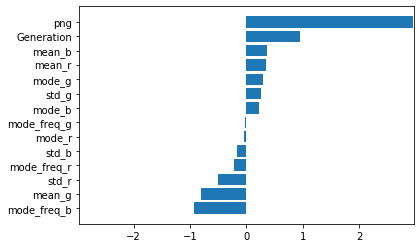

In [112]:
coefs = models['Logistic Regression (L1)'].best_estimator_.coef_.mean(axis=0)
plt.barh(df_feat_color.columns[np.argsort(coefs)], np.sort(coefs))
plt.xlim(-max(abs(coefs)) -0.01, max(abs(coefs))+0.01)

Interestingly, the top feature for the logistic regression is the file type of the image processed (PNG or JPG). As observed earlier, the PNG is for pokemons from Gen I to Gen VI while the filetype of the most recent Gen VII are all JPG. While this is not a color feature, it is interesting to see how it is a more significant feature than the colors (which could be attributed to the difference in style from the first generations to the last ones). Note that Gen VII is where Alolan pokemons are introduced, signifying a change in style which was captured by this model.

In [113]:
df_acc_prim_color_types[['Test Accuracy']]

,Test Accuracy
Flying,0.000000
Fairy,0.200000
Ice,0.285714
Steel,0.000000
Ghost,0.000000
Dragon,0.000000
Fighting,0.000000
Dark,0.400000
Ground,0.000000
Poison,0.500000


In [114]:
cols = ['Machine Learning Method', 'Test Accuracy',
        'Best Parameter', 'Top Predictor Variable']
df_acc_prim_color_gen = pd.DataFrame(columns=cols)
gen_scaled = dict(zip(range(1, 8), np.unique(X_val[:, -1])))

# for i, m in enumerate(models):
m = 'Logistic Regression (L1)'

for i in range(1,8):
    try:
        top_predictor = dict(zip(X.columns, np.abs(models[m].best_estimator_.coef_).mean(axis=0)))

    except AttributeError:
        top_predictor = np.nan
    
    df_acc_prim_color_gen.loc[i] = [m, 
                     models[m].best_estimator_.score(X_val[X_val[:, -1]==gen_scaled[i]], y_val[X_val[:, -1]==gen_scaled[i]]),
                     models[m].best_params_ ,
                     top_predictor]

In [115]:
df_acc_prim_color_gen['Generation'] = ['I', 'II', 'III', 'IV', 'V', 'VI', 'VII']
df_acc_prim_color_gen.set_index('Generation', inplace=True)
df_acc_prim_color_gen[['Test Accuracy']]

,Test Accuracy
Generation,
I,0.342105
II,0.409091
III,0.212121
IV,0.125000
V,0.250000
VI,0.190476
VII,0.238095


#### Size features only

In [116]:
cl1 = KNeighborsClassifier(n_jobs=-1)
cl2 = LogisticRegression(penalty='l1', max_iter=1000,
                         solver='liblinear', n_jobs=-1)
cl3 = LogisticRegression(penalty='l2', max_iter=1000, n_jobs=-1)
cl4 = LinearSVC(penalty='l1', dual=False, max_iter=10000)
cl5 = LinearSVC(penalty='l2', max_iter=10000)
cl6 = SVC(kernel='rbf', )
cl7 = SVC(kernel='poly', degree=3)
cl8 = DecisionTreeClassifier()
cl9 = RandomForestClassifier(max_features='sqrt')
cl10 = GradientBoostingClassifier()
kneighbors = range(1, 31)
C_list = np.logspace(-5, 5, num=10)
gamma_list = np.logspace(-5, 5, num=10)

estimators = [('KNN', cl1, {'n_neighbors':kneighbors}),
              ('Logistic Regression (L1)', cl2, {'C':C_list}),
              ('Logistic Regression (L2)', cl3, {'C':C_list}),
              ('Linear SVM (L1)', cl4, {'C':C_list}),
              ('Linear SVM (L2)', cl5, {'C':C_list}),
              ('NonLinear SVM (RBF)', cl6, {'C':C_list,
                                            'gamma':gamma_list}),
              ('NonLinear SVM (Poly)', cl7, {'C':C_list,
                                             'gamma':gamma_list}),
              ('Decision Tree', cl8, {'max_depth':range(1,11),
                                      'criterion':['gini', 'entropy']}),
              ('Random Forest', cl9, {'max_depth':range(1,4),
                                      'n_estimators':range(10,101,10),
                                      'criterion':['gini', 'entropy']}),
              ('GBM', cl10, {'max_depth':range(1,4),
                            'n_estimators':range(10,101,10),
                            'learning_rate':np.arange(0.1,1.01,0.1)})]

In [117]:
X = df_feat_size
X['Generation'] = df['Generation'].astype(float)
y = df_target_A

X_train, X_val, y_train, y_val = model_selection.train_test_split(X, y,
                                                            random_state=1)
scaler = preprocessing.RobustScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [118]:
models = {}
for est in estimators[1:2]:
    print(f'Training {est}\n')
    gs_cv = model_selection.GridSearchCV(est[1], param_grid=est[2], n_jobs=4)
    gs_cv.fit(X_train, y_train)
    models[est[0]] = gs_cv

Training ('Logistic Regression (L1)', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=-1, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False), {'C': array([1.00000000e-05, 1.29154967e-04, 1.66810054e-03, 2.15443469e-02,
       2.78255940e-01, 3.59381366e+00, 4.64158883e+01, 5.99484250e+02,
       7.74263683e+03, 1.00000000e+05])})



In [119]:
cols = ['Machine Learning Method', 'Test Accuracy',
        'Best Parameter', 'Top Predictor Variable']
df_acc_prim_size = pd.DataFrame(columns=cols)

for i, m in enumerate(models):
    
    try:
        top_predictor = X.columns[
            np.argmax(np.abs(models[m].best_estimator_.coef_).mean(axis=0))]

    except AttributeError:
        top_predictor = np.nan
    
    df_acc_prim_size.loc[i] = [m, 
                 models[m].best_estimator_.score(X_val, y_val),
                 models[m].best_params_ ,
                 top_predictor]

In [120]:
df_acc_prim_size

,Machine Learning Method,Test Accuracy,Best Parameter,Top Predictor Variable
0,Logistic Regression (L1),0.152709,{'C': 0.2782559402207126},mean_length


(-0.03220882422820588, 0.03220882422820588)

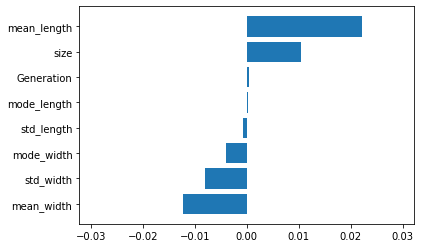

In [121]:
coefs = models['Logistic Regression (L1)'].best_estimator_.coef_.mean(axis=0)
plt.barh(df_feat_size.columns[np.argsort(coefs)], np.sort(coefs))
plt.xlim(-max(abs(coefs)) -0.01, max(abs(coefs))+0.01)

In [122]:
cols = ['Machine Learning Method', 'Test Accuracy',
        'Best Parameter', 'Top Predictor Variable']
df_acc_prim_size_types = pd.DataFrame(columns=cols)

# for i, m in enumerate(models):
m = 'Logistic Regression (L1)'
for i in df_target_A.value_counts().index[::-1]:
    try:
        top_predictor = dict(zip(X.columns, np.abs(models[m].best_estimator_.coef_).mean(axis=0)))

    except AttributeError:
        top_predictor = np.nan
    
    df_acc_prim_size_types.loc[i] = [m, 
                 models[m].best_estimator_.score(X_val[y_val==i], y_val[y_val==i]),
                 models[m].best_params_ ,
                 top_predictor]

In [123]:
df_acc_prim_size_types[['Test Accuracy']]

,Test Accuracy
Flying,0.000000
Fairy,0.000000
Ice,0.000000
Steel,0.000000
Ghost,0.000000
Dragon,0.000000
Fighting,0.000000
Dark,0.000000
Ground,0.000000
Poison,0.000000


In [124]:
cols = ['Machine Learning Method', 'Test Accuracy',
        'Best Parameter', 'Top Predictor Variable']
df_acc_prim_size_gen = pd.DataFrame(columns=cols)
gen_scaled = dict(zip(range(1, 8), np.unique(X_val[:, -1])))

# for i, m in enumerate(models):
m = 'Logistic Regression (L1)'

for i in range(1,8):
    try:
        top_predictor = dict(zip(X.columns, np.abs(models[m].best_estimator_.coef_).mean(axis=0)))

    except AttributeError:
        top_predictor = np.nan
    
    df_acc_prim_size_gen.loc[i] = [m, 
                     models[m].best_estimator_.score(X_val[X_val[:, -1]==gen_scaled[i]], y_val[X_val[:, -1]==gen_scaled[i]]),
                     models[m].best_params_ ,
                     top_predictor]

In [125]:
df_acc_prim_size_gen['Top Predictor Variable'][1]

{'size': 0.04273329086995648,
 'mean_width': 0.0570165363069099,
 'mode_width': 0.03463092006413958,
 'std_width': 0.015373512513715583,
 'mean_length': 0.08742663603608632,
 'mode_length': 0.06474750125990256,
 'std_length': 0.04224160384381795,
 'Generation': 0.03413330599241739}

In [126]:
df_acc_prim_size_gen['Generation'] = ['I', 'II', 'III', 'IV', 'V', 'VI', 'VII']
df_acc_prim_size_gen.set_index('Generation', inplace=True)
df_acc_prim_size_gen[['Test Accuracy']]

,Test Accuracy
Generation,
I,0.263158
II,0.136364
III,0.181818
IV,0.166667
V,0.136364
VI,0.047619
VII,0.047619


<a id="imb-sec"></a>

### Secondary Type only

#### Combined features

In [127]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from warnings import filterwarnings
filterwarnings('ignore')

import importlib

from sklearn import model_selection, preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier


In [128]:
df_target_B = df['Type2']
df_target_B[df_target_B.isnull()] = df['Type1'][df_target_B.isnull()]

Text(0.5, 0, 'Count')

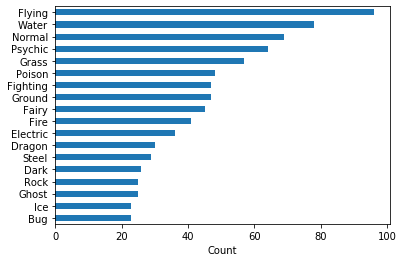

In [129]:
df_target_B.value_counts()[::-1].plot.barh()
plt.xlabel('Count')

In [130]:
print(f'1.25 x PCC = {125*((df_target_B.value_counts() / df_target_B.count())**2).sum():.2f}%')

1.25 x PCC = 8.38%


In [131]:
cl1 = KNeighborsClassifier(n_jobs=-1)
cl2 = LogisticRegression(penalty='l1', max_iter=1000,
                         solver='liblinear', n_jobs=-1)
cl3 = LogisticRegression(penalty='l2', max_iter=1000, n_jobs=-1)
cl4 = LinearSVC(penalty='l1', dual=False, max_iter=10000)
cl5 = LinearSVC(penalty='l2', max_iter=10000)
cl6 = SVC(kernel='rbf', )
cl7 = SVC(kernel='poly', degree=3)
cl8 = DecisionTreeClassifier()
cl9 = RandomForestClassifier(max_features='sqrt')
cl10 = GradientBoostingClassifier()
kneighbors = range(1, 31)
C_list = np.logspace(-5, 5, num=10)
gamma_list = np.logspace(-5, 5, num=10)

estimators = [('KNN', cl1, {'n_neighbors':kneighbors}),
              ('Logistic Regression (L1)', cl2, {'C':C_list}),
              ('Logistic Regression (L2)', cl3, {'C':C_list}),
              ('Linear SVM (L1)', cl4, {'C':C_list}),
              ('Linear SVM (L2)', cl5, {'C':C_list}),
              ('NonLinear SVM (RBF)', cl6, {'C':C_list,
                                            'gamma':gamma_list}),
              ('NonLinear SVM (Poly)', cl7, {'C':C_list,
                                             'gamma':gamma_list}),
              ('Decision Tree', cl8, {'max_depth':range(1,11),
                                      'criterion':['gini', 'entropy']}),
              ('Random Forest', cl9, {'max_depth':range(1,4),
                                      'n_estimators':range(10,101,10),
                                      'criterion':['gini', 'entropy']}),
              ('GBM', cl10, {'max_depth':range(1,4),
                            'n_estimators':range(10,101,10),
                            'learning_rate':np.arange(0.1,1.01,0.1)})]

In [132]:
X = df_feat.astype(float)
y = df_target_B

X_train, X_val, y_train, y_val = model_selection.train_test_split(X, y,
                                                            random_state=1)
scaler = preprocessing.RobustScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [133]:
models = {}
for est in estimators[1:2]:
    print(f'Training {est}\n')
    gs_cv = model_selection.GridSearchCV(est[1], param_grid=est[2], n_jobs=4)
    gs_cv.fit(X_train, y_train)
    models[est[0]] = gs_cv

Training ('Logistic Regression (L1)', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=-1, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False), {'C': array([1.00000000e-05, 1.29154967e-04, 1.66810054e-03, 2.15443469e-02,
       2.78255940e-01, 3.59381366e+00, 4.64158883e+01, 5.99484250e+02,
       7.74263683e+03, 1.00000000e+05])})



In [134]:
cols = ['Machine Learning Method', 'Test Accuracy',
        'Best Parameter', 'Top Predictor Variable']
df_acc_sec_all = pd.DataFrame(columns=cols)

for i, m in enumerate(models):
    
    try:
        top_predictor = X.columns[
            np.argmax(np.abs(models[m].best_estimator_.coef_).mean(axis=0))]

    except AttributeError:
        top_predictor = np.nan
    
    df_acc_sec_all.loc[i] = [m, 
                 models[m].best_estimator_.score(X_val, y_val),
                 models[m].best_params_ ,
                 top_predictor]

In [135]:
df_acc_sec_all

,Machine Learning Method,Test Accuracy,Best Parameter,Top Predictor Variable
0,Logistic Regression (L1),0.236453,{'C': 46.41588833612782},png


(-0.8798309186889557, 0.8798309186889557)

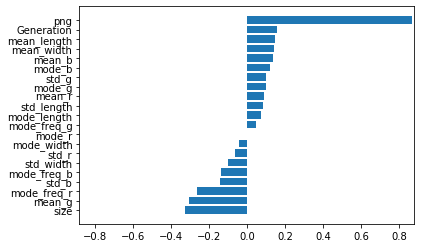

In [136]:
coefs = models['Logistic Regression (L1)'].best_estimator_.coef_.mean(axis=0)
plt.barh(df_feat.columns[np.argsort(coefs)], np.sort(coefs))
plt.xlim(-max(abs(coefs)) -0.01, max(abs(coefs))+0.01)

In [137]:
cols = ['Machine Learning Method', 'Test Accuracy',
        'Best Parameter', 'Top Predictor Variable']
df_acc_sec_all_types = pd.DataFrame(columns=cols)

# for i, m in enumerate(models):
m = 'Logistic Regression (L1)'
for i in df_target_B.value_counts().index[::-1]:
    try:
        top_predictor = dict(zip(X.columns, np.abs(models[m].best_estimator_.coef_).mean(axis=0)))

    except AttributeError:
        top_predictor = np.nan
    
    df_acc_sec_all_types.loc[i] = [m, 
                 models[m].best_estimator_.score(X_val[y_val==i], y_val[y_val==i]),
                 models[m].best_params_ ,
                 top_predictor]

In [138]:
df_acc_sec_all_types[['Test Accuracy']]

,Test Accuracy
Bug,0.000000
Ice,0.666667
Ghost,0.333333
Rock,0.000000
Dark,0.300000
Steel,0.200000
Dragon,0.000000
Electric,0.000000
Fire,0.555556
Fairy,0.333333


In [139]:
cols = ['Machine Learning Method', 'Test Accuracy',
        'Best Parameter', 'Top Predictor Variable']
df_acc_sec_all_gen = pd.DataFrame(columns=cols)
gen_scaled = dict(zip(range(1, 8), np.unique(X_val[:, -1])))

# for i, m in enumerate(models):
m = 'Logistic Regression (L1)'

for i in range(1,8):
    try:
        top_predictor = dict(zip(X.columns, np.abs(models[m].best_estimator_.coef_).mean(axis=0)))

    except AttributeError:
        top_predictor = np.nan
    
    df_acc_sec_all_gen.loc[i] = [m, 
                     models[m].best_estimator_.score(X_val[X_val[:, -1]==gen_scaled[i]], y_val[X_val[:, -1]==gen_scaled[i]]),
                     models[m].best_params_ ,
                     top_predictor]

In [140]:
df_acc_sec_all_gen['Top Predictor Variable'][1]

{'mean_r': 1.1309017255658198,
 'mean_g': 1.01876380808323,
 'mean_b': 0.7638530126264487,
 'mode_r': 0.8277410223760405,
 'mode_g': 0.6626352210532551,
 'mode_b': 0.7293648544757625,
 'mode_freq_r': 0.7539064357299494,
 'mode_freq_g': 0.453068676027666,
 'mode_freq_b': 0.4589230104563115,
 'std_r': 0.5246302674007338,
 'std_g': 0.5394443980717021,
 'std_b': 0.5641206905991735,
 'png': 1.5723762932090262,
 'size': 1.2349990173624372,
 'mean_width': 1.0738353984688074,
 'mode_width': 0.3798777619263852,
 'std_width': 0.4845224650436984,
 'mean_length': 0.5964029257831089,
 'mode_length': 0.4561151254276408,
 'std_length': 0.618493119668619,
 'Generation': 0.6185002819148505}

In [141]:
df_acc_sec_all_gen['Generation'] = ['I', 'II', 'III', 'IV', 'V', 'VI', 'VII']
df_acc_sec_all_gen.set_index('Generation', inplace=True)
df_acc_sec_all_gen[['Test Accuracy']]

,Test Accuracy
Generation,
I,0.289474
II,0.181818
III,0.121212
IV,0.333333
V,0.272727
VI,0.333333
VII,0.095238


#### Color features only

In [142]:
cl1 = KNeighborsClassifier(n_jobs=-1)
cl2 = LogisticRegression(penalty='l1', max_iter=1000,
                         solver='liblinear', n_jobs=-1)
cl3 = LogisticRegression(penalty='l2', max_iter=1000, n_jobs=-1)
cl4 = LinearSVC(penalty='l1', dual=False, max_iter=10000)
cl5 = LinearSVC(penalty='l2', max_iter=10000)
cl6 = SVC(kernel='rbf', )
cl7 = SVC(kernel='poly', degree=3)
cl8 = DecisionTreeClassifier()
cl9 = RandomForestClassifier(max_features='sqrt')
cl10 = GradientBoostingClassifier()
kneighbors = range(1, 31)
C_list = np.logspace(-5, 5, num=10)
gamma_list = np.logspace(-5, 5, num=10)

estimators = [('KNN', cl1, {'n_neighbors':kneighbors}),
              ('Logistic Regression (L1)', cl2, {'C':C_list}),
              ('Logistic Regression (L2)', cl3, {'C':C_list}),
              ('Linear SVM (L1)', cl4, {'C':C_list}),
              ('Linear SVM (L2)', cl5, {'C':C_list}),
              ('NonLinear SVM (RBF)', cl6, {'C':C_list,
                                            'gamma':gamma_list}),
              ('NonLinear SVM (Poly)', cl7, {'C':C_list,
                                             'gamma':gamma_list}),
              ('Decision Tree', cl8, {'max_depth':range(1,11),
                                      'criterion':['gini', 'entropy']}),
              ('Random Forest', cl9, {'max_depth':range(1,4),
                                      'n_estimators':range(10,101,10),
                                      'criterion':['gini', 'entropy']}),
              ('GBM', cl10, {'max_depth':range(1,4),
                            'n_estimators':range(10,101,10),
                            'learning_rate':np.arange(0.1,1.01,0.1)})]

In [143]:
df.head()

,Name,Type1,Type2,Generation
Pokedex Number,,,,
1,bulbasaur,Grass,Poison,1.0
2,ivysaur,Grass,Poison,1.0
3,venusaur,Grass,Poison,1.0
4,charmander,Fire,Fire,1.0
5,charmeleon,Fire,Fire,1.0


In [144]:
X = df_feat_color
X['Generation'] = df['Generation'].astype(float)
y = df_target_B

X_train, X_val, y_train, y_val = model_selection.train_test_split(X, y,
                                                            random_state=1)
scaler = preprocessing.RobustScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [145]:
models = {}
for est in estimators[1:2]:
    print(f'Training {est}\n')
    gs_cv = model_selection.GridSearchCV(est[1], param_grid=est[2], n_jobs=4)
    gs_cv.fit(X_train, y_train)
    models[est[0]] = gs_cv

Training ('Logistic Regression (L1)', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=-1, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False), {'C': array([1.00000000e-05, 1.29154967e-04, 1.66810054e-03, 2.15443469e-02,
       2.78255940e-01, 3.59381366e+00, 4.64158883e+01, 5.99484250e+02,
       7.74263683e+03, 1.00000000e+05])})



In [146]:
cols = ['Machine Learning Method', 'Test Accuracy',
        'Best Parameter', 'Top Predictor Variable']
df_acc_sec_color = pd.DataFrame(columns=cols)

for i, m in enumerate(models):
    
    try:
        top_predictor = X.columns[
            np.argmax(np.abs(models[m].best_estimator_.coef_).mean(axis=0))]

    except AttributeError:
        top_predictor = np.nan
    
    df_acc_sec_color.loc[i] = [m, 
                 models[m].best_estimator_.score(X_val, y_val),
                 models[m].best_params_ ,
                 top_predictor]

In [147]:
df_acc_sec_color

,Machine Learning Method,Test Accuracy,Best Parameter,Top Predictor Variable
0,Logistic Regression (L1),0.221675,{'C': 46.41588833612782},png


(-0.8885043375912951, 0.8885043375912951)

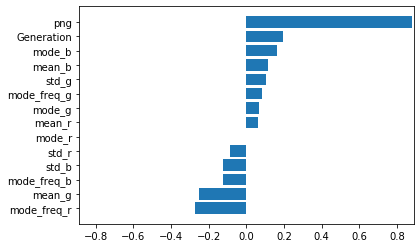

In [148]:
coefs = models['Logistic Regression (L1)'].best_estimator_.coef_.mean(axis=0)
plt.barh(df_feat_color.columns[np.argsort(coefs)], np.sort(coefs))
plt.xlim(-max(abs(coefs)) -0.01, max(abs(coefs))+0.01)

In [149]:
cols = ['Machine Learning Method', 'Test Accuracy',
        'Best Parameter', 'Top Predictor Variable']
df_acc_sec_color_types = pd.DataFrame(columns=cols)

# for i, m in enumerate(models):
m = 'Logistic Regression (L1)'
for i in df_target_B.value_counts().index[::-1]:
    try:
        top_predictor = dict(zip(X.columns, np.abs(models[m].best_estimator_.coef_).mean(axis=0)))

    except AttributeError:
        top_predictor = np.nan
    
    df_acc_sec_color_types.loc[i] = [m, 
                 models[m].best_estimator_.score(X_val[y_val==i], y_val[y_val==i]),
                 models[m].best_params_ ,
                 top_predictor]

In [150]:
df_acc_sec_color_types[['Test Accuracy']]

,Test Accuracy
Bug,0.000000
Ice,0.666667
Ghost,0.000000
Rock,0.000000
Dark,0.300000
Steel,0.200000
Dragon,0.000000
Electric,0.100000
Fire,0.444444
Fairy,0.333333


In [151]:
cols = ['Machine Learning Method', 'Test Accuracy',
        'Best Parameter', 'Top Predictor Variable']
df_acc_sec_color_gen = pd.DataFrame(columns=cols)
gen_scaled = dict(zip(range(1, 8), np.unique(X_val[:, -1])))

# for i, m in enumerate(models):
m = 'Logistic Regression (L1)'

for i in range(1,8):
    try:
        top_predictor = dict(zip(X.columns, np.abs(models[m].best_estimator_.coef_).mean(axis=0)))

    except AttributeError:
        top_predictor = np.nan
    
    df_acc_sec_color_gen.loc[i] = [m, 
                     models[m].best_estimator_.score(X_val[X_val[:, -1]==gen_scaled[i]], y_val[X_val[:, -1]==gen_scaled[i]]),
                     models[m].best_params_ ,
                     top_predictor]

In [152]:
df_acc_sec_color_gen['Top Predictor Variable'][1]

{'mean_r': 1.0489141643160076,
 'mean_g': 0.9655245277154683,
 'mean_b': 0.7871276807751699,
 'mode_r': 0.8407083351620557,
 'mode_g': 0.6439534706367539,
 'mode_b': 0.7370186605874696,
 'mode_freq_r': 0.7245742359421679,
 'mode_freq_g': 0.42293578005646265,
 'mode_freq_b': 0.41548935144391475,
 'std_r': 0.4687692280370862,
 'std_g': 0.5295675721824948,
 'std_b': 0.549991652367419,
 'png': 1.436684834719361,
 'Generation': 0.6309670188545896}

In [153]:
df_acc_sec_color_gen['Generation'] = ['I', 'II', 'III', 'IV', 'V', 'VI', 'VII']
df_acc_sec_color_gen.set_index('Generation', inplace=True)
df_acc_sec_color_gen[['Test Accuracy']]

,Test Accuracy
Generation,
I,0.263158
II,0.227273
III,0.121212
IV,0.250000
V,0.295455
VI,0.285714
VII,0.047619


#### Size features only

In [154]:
cl1 = KNeighborsClassifier(n_jobs=-1)
cl2 = LogisticRegression(penalty='l1', max_iter=1000,
                         solver='liblinear', n_jobs=-1)
cl3 = LogisticRegression(penalty='l2', max_iter=1000, n_jobs=-1)
cl4 = LinearSVC(penalty='l1', dual=False, max_iter=10000)
cl5 = LinearSVC(penalty='l2', max_iter=10000)
cl6 = SVC(kernel='rbf', )
cl7 = SVC(kernel='poly', degree=3)
cl8 = DecisionTreeClassifier()
cl9 = RandomForestClassifier(max_features='sqrt')
cl10 = GradientBoostingClassifier()
kneighbors = range(1, 31)
C_list = np.logspace(-5, 5, num=10)
gamma_list = np.logspace(-5, 5, num=10)

estimators = [('KNN', cl1, {'n_neighbors':kneighbors}),
              ('Logistic Regression (L1)', cl2, {'C':C_list}),
              ('Logistic Regression (L2)', cl3, {'C':C_list}),
              ('Linear SVM (L1)', cl4, {'C':C_list}),
              ('Linear SVM (L2)', cl5, {'C':C_list}),
              ('NonLinear SVM (RBF)', cl6, {'C':C_list,
                                            'gamma':gamma_list}),
              ('NonLinear SVM (Poly)', cl7, {'C':C_list,
                                             'gamma':gamma_list}),
              ('Decision Tree', cl8, {'max_depth':range(1,11),
                                      'criterion':['gini', 'entropy']}),
              ('Random Forest', cl9, {'max_depth':range(1,4),
                                      'n_estimators':range(10,101,10),
                                      'criterion':['gini', 'entropy']}),
              ('GBM', cl10, {'max_depth':range(1,4),
                            'n_estimators':range(10,101,10),
                            'learning_rate':np.arange(0.1,1.01,0.1)})]

In [155]:
X = df_feat_size
X['Generation'] = df['Generation'].astype(float)
y = df_target_B

X_train, X_val, y_train, y_val = model_selection.train_test_split(X, y,
                                                            random_state=1)
scaler = preprocessing.RobustScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [156]:
models = {}
for est in estimators[1:2]:
    print(f'Training {est}\n')
    gs_cv = model_selection.GridSearchCV(est[1], param_grid=est[2], n_jobs=4)
    gs_cv.fit(X_train, y_train)
    models[est[0]] = gs_cv

Training ('Logistic Regression (L1)', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=-1, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False), {'C': array([1.00000000e-05, 1.29154967e-04, 1.66810054e-03, 2.15443469e-02,
       2.78255940e-01, 3.59381366e+00, 4.64158883e+01, 5.99484250e+02,
       7.74263683e+03, 1.00000000e+05])})



In [157]:
cols = ['Machine Learning Method', 'Test Accuracy',
        'Best Parameter', 'Top Predictor Variable']
df_acc_sec_size = pd.DataFrame(columns=cols)

for i, m in enumerate(models):
    
    try:
        top_predictor = X.columns[
            np.argmax(np.abs(models[m].best_estimator_.coef_).mean(axis=0))]

    except AttributeError:
        top_predictor = np.nan
    
    df_acc_sec_size.loc[i] = [m, 
                 models[m].best_estimator_.score(X_val, y_val),
                 models[m].best_params_ ,
                 top_predictor]

In [158]:
df_acc_sec_size

,Machine Learning Method,Test Accuracy,Best Parameter,Top Predictor Variable
0,Logistic Regression (L1),0.118227,{'C': 0.2782559402207126},Generation


(-0.045855892880581305, 0.045855892880581305)

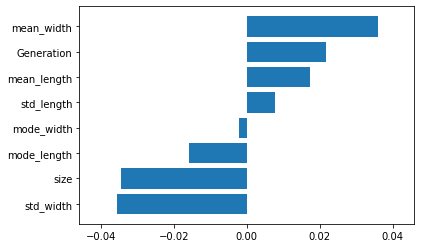

In [159]:
coefs = models['Logistic Regression (L1)'].best_estimator_.coef_.mean(axis=0)
plt.barh(df_feat_size.columns[np.argsort(coefs)], np.sort(coefs))
plt.xlim(-max(abs(coefs)) -0.01, max(abs(coefs))+0.01)

In [160]:
cols = ['Machine Learning Method', 'Test Accuracy',
        'Best Parameter', 'Top Predictor Variable']
df_acc_sec_size_types = pd.DataFrame(columns=cols)

# for i, m in enumerate(models):
m = 'Logistic Regression (L1)'
for i in df_target_B.value_counts().index[::-1]:
    try:
        top_predictor = dict(zip(X.columns, np.abs(models[m].best_estimator_.coef_).mean(axis=0)))

    except AttributeError:
        top_predictor = np.nan
    
    df_acc_sec_size_types.loc[i] = [m, 
                 models[m].best_estimator_.score(X_val[y_val==i], y_val[y_val==i]),
                 models[m].best_params_ ,
                 top_predictor]

In [161]:
df_acc_sec_size_types[['Test Accuracy']]

,Test Accuracy
Bug,0.000000
Ice,0.000000
Ghost,0.000000
Rock,0.000000
Dark,0.000000
Steel,0.000000
Dragon,0.000000
Electric,0.000000
Fire,0.000000
Fairy,0.166667


In [162]:
cols = ['Machine Learning Method', 'Test Accuracy',
        'Best Parameter', 'Top Predictor Variable']
df_acc_sec_size_gen = pd.DataFrame(columns=cols)
gen_scaled = dict(zip(range(1, 8), np.unique(X_val[:, -1])))

# for i, m in enumerate(models):
m = 'Logistic Regression (L1)'

for i in range(1,8):
    try:
        top_predictor = dict(zip(X.columns, np.abs(models[m].best_estimator_.coef_).mean(axis=0)))

    except AttributeError:
        top_predictor = np.nan
    
    df_acc_sec_size_gen.loc[i] = [m, 
                     models[m].best_estimator_.score(X_val[X_val[:, -1]==gen_scaled[i]], y_val[X_val[:, -1]==gen_scaled[i]]),
                     models[m].best_params_ ,
                     top_predictor]

In [163]:
df_acc_sec_size_gen['Top Predictor Variable'][1]

{'size': 0.04152374006783139,
 'mean_width': 0.08251728271158644,
 'mode_width': 0.037621426146925395,
 'std_width': 0.12446818133600407,
 'mean_length': 0.08135828626445102,
 'mode_length': 0.0783503106901134,
 'std_length': 0.08498692666930616,
 'Generation': 0.17694785326190432}

In [164]:
df_acc_sec_size_gen['Generation'] = ['I', 'II', 'III', 'IV', 'V', 'VI', 'VII']
df_acc_sec_size_gen.set_index('Generation', inplace=True)
df_acc_sec_size_gen[['Test Accuracy']]

,Test Accuracy
Generation,
I,0.078947
II,0.090909
III,0.060606
IV,0.166667
V,0.136364
VI,0.142857
VII,0.190476


<a id="imb-sum"></a>

### Summary (Imbalanced)
We summarize and compare our results for the imbalanced dataset as follows:

For the prediction accuracy of different Pokemon types, the best set of features are shown below:

In [165]:
df_prim_types = pd.DataFrame()
df_prim_types['All Features'] = df_acc_prim_all_types['Test Accuracy']
df_prim_types['Color Features'] = df_acc_prim_color_types['Test Accuracy']
df_prim_types['Size Features'] = df_acc_prim_size_types['Test Accuracy']
# df_acc_sec_size_gen
df_prim_types['Best set of features'] = df_prim_types.idxmax(axis=1)
df_prim_types.loc[df_prim_types[['All Features', 'Color Features', 'Size Features']].sum(axis=1)==0, 'Best set of features'] = 'None of the above'

df_prim_types['Primary Type'] = df_prim_types.index
df_prim_types.set_index('Primary Type', inplace=True)
df_prim_types

,All Features,Color Features,Size Features,Best set of features
Primary Type,,,,
Flying,0.000000,0.000000,0.000000,None of the above
Fairy,0.200000,0.200000,0.000000,All Features
Ice,0.285714,0.285714,0.000000,All Features
Steel,0.000000,0.000000,0.000000,None of the above
Ghost,0.333333,0.000000,0.000000,All Features
Dragon,0.000000,0.000000,0.000000,None of the above
Fighting,0.000000,0.000000,0.000000,None of the above
Dark,0.400000,0.400000,0.000000,All Features
Ground,0.000000,0.000000,0.000000,None of the above


For different Pokemon types, it is noticeable how a different combination of features yields different accuracies for the classification. For example, types like Poison are best modeled using color features only due to their distinct violet color while Normal type Pokemon are different to classify using colors and are actually best predicted using size features.

In [166]:
df_prim_gen = pd.DataFrame()
df_prim_gen['All Features'] = df_acc_prim_all_gen['Test Accuracy']
df_prim_gen['Color Features'] = df_acc_prim_color_gen['Test Accuracy']
df_prim_gen['Size Features'] = df_acc_prim_size_gen['Test Accuracy']
# df_acc_sec_size_gen
df_prim_gen['Best set of features'] = df_prim_gen.idxmax(axis=1)
df_prim_gen.loc[df_prim_gen[['All Features', 'Color Features', 'Size Features']].sum(axis=1)==0, 'Best set of features'] = 'None of the above'

df_prim_gen['Generation'] = df_prim_gen.index
df_prim_gen.set_index('Generation', inplace=True)
df_prim_gen

,All Features,Color Features,Size Features,Best set of features
Generation,,,,
I,0.368421,0.342105,0.263158,All Features
II,0.318182,0.409091,0.136364,Color Features
III,0.181818,0.212121,0.181818,Color Features
IV,0.125000,0.125000,0.166667,Size Features
V,0.340909,0.250000,0.136364,All Features
VI,0.238095,0.190476,0.047619,All Features
VII,0.142857,0.238095,0.047619,Color Features


Across different generations, different types of Pokemon are introduced. This is why there are no significant differences across different generation groups on the accuracies for different set of features.

Now, we summarize the results for classification of Pokemon secondary types.

In [167]:
df_sec_types = pd.DataFrame()
df_sec_types['All Features'] = df_acc_sec_all_types['Test Accuracy']
df_sec_types['Color Features'] = df_acc_sec_color_types['Test Accuracy']
df_sec_types['Size Features'] = df_acc_sec_size_types['Test Accuracy']
# df_acc_sec_size_gen
df_sec_types['Best set of features'] = df_sec_types.idxmax(axis=1)
df_sec_types.loc[df_sec_types[['All Features', 'Color Features', 'Size Features']].sum(axis=1)==0, 'Best set of features'] = 'None of the above'


df_sec_types['Secondary Type'] = df_sec_types.index
df_sec_types.set_index('Secondary Type', inplace=True)
df_sec_types

,All Features,Color Features,Size Features,Best set of features
Secondary Type,,,,
Bug,0.000000,0.000000,0.000000,None of the above
Ice,0.666667,0.666667,0.000000,All Features
Ghost,0.333333,0.000000,0.000000,All Features
Rock,0.000000,0.000000,0.000000,None of the above
Dark,0.300000,0.300000,0.000000,All Features
Steel,0.200000,0.200000,0.000000,All Features
Dragon,0.000000,0.000000,0.000000,None of the above
Electric,0.000000,0.100000,0.000000,Color Features
Fire,0.555556,0.444444,0.000000,All Features


Note that the data here is still imbalanced but similar observation can be made here wherein different set of features yield different accuracies for different Pokemon typings. Interestingly, there are less zero accuracies here than the Primary types, which could be an indicator of the higher predictability of Secondary Types rather than the Primary Types with our features. However, it could also be an artifact of the distribution of classes for the Secondary Types. We will stop that analysis there and balance the data instead to obtain better accuracies.

In [168]:
df_sec_gen = pd.DataFrame()
df_sec_gen['All Features'] = df_acc_sec_all_gen['Test Accuracy']
df_sec_gen['Color Features'] = df_acc_sec_color_gen['Test Accuracy']
df_sec_gen['Size Features'] = df_acc_sec_size_gen['Test Accuracy']
# df_acc_sec_size_gen
df_sec_gen['Best set of features'] = df_sec_gen.idxmax(axis=1)
df_sec_gen.loc[df_sec_gen[['All Features', 'Color Features', 'Size Features']].sum(axis=1)==0, 'Best set of features'] = 'None of the above'


df_sec_gen['Generation'] = df_sec_gen.index
df_sec_gen.set_index('Generation', inplace=True)
df_sec_gen

,All Features,Color Features,Size Features,Best set of features
Generation,,,,
I,0.289474,0.263158,0.078947,All Features
II,0.181818,0.227273,0.090909,Color Features
III,0.121212,0.121212,0.060606,All Features
IV,0.333333,0.250000,0.166667,All Features
V,0.272727,0.295455,0.136364,Color Features
VI,0.333333,0.285714,0.142857,All Features
VII,0.095238,0.047619,0.190476,Size Features


Similar to the Primary Types, there are no significant differences in the use of different set of features for the accuracies of Pokemons from different generations.

<a id="balanced"></a>

# Data balancing through undersampling
As mentioned earlier, the data is quite imbalanced. For this analysis, we will use undersampling with two purposes:
1. Make the data balanced
2. Reduce the target classes to improve predictability

Again, we perform this analysis by considering the Primary Type and the Secondary Type as the target separately. The following steps will not be discussed as the methodology employed here will be the same as the <a href='#imbalanced'>imbalanced dataset</a>

<a id="bal-main"></a>

### Primary Type

From the original dataset:

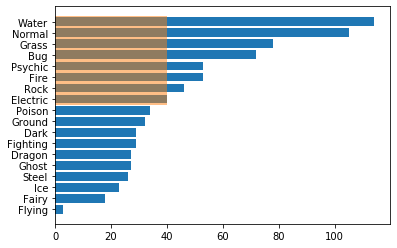

In [169]:
types = df_target_A.value_counts()
plt.barh(types.index[::-1], types.values[::-1])
plt.fill_between([0, 40], [9.5, 9.5], [17.5, 17.5], zorder=2, alpha=0.5)

The orange filled area will be the sampled data.

In [170]:
thresholded_A = pd.Series(df_target_A.index.values, index=df_target_A)[df_target_A.value_counts()>=40]
df_target_A_balanced = df_target_A[thresholded_A]

In [171]:
df_temp = df_target_A_balanced.groupby(df_target_A_balanced).apply(lambda x: x.sample(n=40)).reset_index(level=1)
df_temp.set_index('Pokedex Number', inplace=True)

df_target_A_balanced = df_target_A_balanced[df_temp.index]

#### Combined features

In [172]:
df_feat_balanced = df_feat.loc[thresholded_A]
df_feat_balanced = df_feat_balanced.loc[df_temp.index]

In [173]:
cl1 = KNeighborsClassifier(n_jobs=-1)
cl2 = LogisticRegression(penalty='l1', max_iter=1000,
                         solver='liblinear', n_jobs=-1)
cl3 = LogisticRegression(penalty='l2', max_iter=1000, n_jobs=-1)
cl4 = LinearSVC(penalty='l1', dual=False, max_iter=10000)
cl5 = LinearSVC(penalty='l2', max_iter=10000)
cl6 = SVC(kernel='rbf', )
cl7 = SVC(kernel='poly', degree=3)
cl8 = DecisionTreeClassifier()
cl9 = RandomForestClassifier(max_features='sqrt')
cl10 = GradientBoostingClassifier()
kneighbors = range(1, 31)
C_list = np.logspace(-5, 5, num=10)
gamma_list = np.logspace(-5, 5, num=10)

estimators = [('KNN', cl1, {'n_neighbors':kneighbors}),
              ('Logistic Regression (L1)', cl2, {'C':C_list}),
              ('Logistic Regression (L2)', cl3, {'C':C_list}),
              ('Linear SVM (L1)', cl4, {'C':C_list}),
              ('Linear SVM (L2)', cl5, {'C':C_list}),
              ('NonLinear SVM (RBF)', cl6, {'C':C_list,
                                            'gamma':gamma_list}),
              ('NonLinear SVM (Poly)', cl7, {'C':C_list,
                                             'gamma':gamma_list}),
              ('Decision Tree', cl8, {'max_depth':range(1,11),
                                      'criterion':['gini', 'entropy']}),
              ('Random Forest', cl9, {'max_depth':range(1,4),
                                      'n_estimators':range(10,101,10),
                                      'criterion':['gini', 'entropy']}),
              ('GBM', cl10, {'max_depth':range(1,4),
                            'n_estimators':range(10,101,10),
                            'learning_rate':np.arange(0.1,1.01,0.1)})]

In [174]:
X = df_feat_balanced.astype(float)
y = df_target_A_balanced

X_train, X_val, y_train, y_val = model_selection.train_test_split(X, y,
                                                            random_state=1)
scaler = preprocessing.RobustScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [ ]:
models = {}
for est in estimators:
    print(f'Training {est}\n')
    gs_cv = model_selection.GridSearchCV(est[1], param_grid=est[2], n_jobs=4)
    gs_cv.fit(X_train, y_train)
    models[est[0]] = gs_cv

Training ('KNN', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform'), {'n_neighbors': range(1, 31)})

Training ('Logistic Regression (L1)', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=-1, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False), {'C': array([1.00000000e-05, 1.29154967e-04, 1.66810054e-03, 2.15443469e-02,
       2.78255940e-01, 3.59381366e+00, 4.64158883e+01, 5.99484250e+02,
       7.74263683e+03, 1.00000000e+05])})

Training ('Logistic Regression (L2)', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   mu

In [ ]:
cols = ['Machine Learning Method', 'Test Accuracy',
        'Best Parameter', 'Top Predictor Variable']
df_acc_prim_bal = pd.DataFrame(columns=cols)

for i, m in enumerate(models):
    
    try:
        top_predictor = dict(zip(X.columns, np.abs(models[m].best_estimator_.coef_).mean(axis=0)))

    except AttributeError:
        top_predictor = np.nan
    
    df_acc_prim_bal.loc[i] = [m, 
                 models[m].best_estimator_.score(X_val, y_val),
                 models[m].best_params_ ,
                 top_predictor]

In [ ]:
df_acc_prim_bal

This is the only difference in the analysis above - the model used here is Linear SVM (L1).

In [ ]:
coefs = models['Linear SVM (L1)'].best_estimator_.coef_.mean(axis=0)
plt.barh(df_feat.columns[np.argsort(coefs)], np.sort(coefs))
plt.xlim(-max(abs(coefs)) -0.01, max(abs(coefs))+0.01)

In [ ]:
cols = ['Machine Learning Method', 'Test Accuracy',
        'Best Parameter', 'Top Predictor Variable']
df_acc_prim_bal_types = pd.DataFrame(columns=cols)

# for i, m in enumerate(models):
m = 'Linear SVM (L1)'
for i in df_target_A_balanced.value_counts().index[::-1]:
    try:
        top_predictor = X.columns[np.argmax(np.abs(models[m].best_estimator_.coef_).mean(axis=0))]

    except AttributeError:
        top_predictor = np.nan
    
    df_acc_prim_bal_types.loc[i] = [m, 
                 models[m].best_estimator_.score(X_val[y_val==i], y_val[y_val==i]),
                 models[m].best_params_ ,
                 top_predictor]

In [ ]:
df_acc_prim_bal_types[['Test Accuracy']]

In [ ]:
cols = ['Machine Learning Method', 'Test Accuracy',
        'Best Parameter', 'Top Predictor Variable']
df_acc_prim_bal_gen = pd.DataFrame(columns=cols)
gen_scaled = dict(zip(range(1, 8), np.unique(X_val[:, -1])))

# for i, m in enumerate(models):
m = 'Linear SVM (L1)'

for i in range(1,8):
    try:
        top_predictor = dict(zip(X.columns, np.abs(models[m].best_estimator_.coef_).mean(axis=0)))

    except AttributeError:
        top_predictor = np.nan
    
    df_acc_prim_bal_gen.loc[i] = [m, 
                     models[m].best_estimator_.score(X_val[X_val[:, -1]==gen_scaled[i]], y_val[X_val[:, -1]==gen_scaled[i]]),
                     models[m].best_params_ ,
                     top_predictor]

In [ ]:
df_acc_prim_bal_gen['Top Predictor Variable'][1]

In [ ]:
df_acc_prim_bal_gen['Generation'] = ['I', 'II', 'III', 'IV', 'V', 'VI', 'VII']
df_acc_prim_bal_gen.set_index('Generation', inplace=True)
df_acc_prim_bal_gen[['Test Accuracy']]

#### Color features only

In [ ]:
df_feat_color_balanced = df_feat_color.loc[thresholded_A]
df_feat_color_balanced = df_feat_color_balanced.loc[df_temp.index]

In [ ]:
cl1 = KNeighborsClassifier(n_jobs=-1)
cl2 = LogisticRegression(penalty='l1', max_iter=1000,
                         solver='liblinear', n_jobs=-1)
cl3 = LogisticRegression(penalty='l2', max_iter=1000, n_jobs=-1)
cl4 = LinearSVC(penalty='l1', dual=False, max_iter=10000)
cl5 = LinearSVC(penalty='l2', max_iter=10000)
cl6 = SVC(kernel='rbf', )
cl7 = SVC(kernel='poly', degree=3)
cl8 = DecisionTreeClassifier()
cl9 = RandomForestClassifier(max_features='sqrt')
cl10 = GradientBoostingClassifier()
kneighbors = range(1, 31)
C_list = np.logspace(-5, 5, num=10)
gamma_list = np.logspace(-5, 5, num=10)

estimators = [('KNN', cl1, {'n_neighbors':kneighbors}),
              ('Logistic Regression (L1)', cl2, {'C':C_list}),
              ('Logistic Regression (L2)', cl3, {'C':C_list}),
              ('Linear SVM (L1)', cl4, {'C':C_list}),
              ('Linear SVM (L2)', cl5, {'C':C_list}),
              ('NonLinear SVM (RBF)', cl6, {'C':C_list,
                                            'gamma':gamma_list}),
              ('NonLinear SVM (Poly)', cl7, {'C':C_list,
                                             'gamma':gamma_list}),
              ('Decision Tree', cl8, {'max_depth':range(1,11),
                                      'criterion':['gini', 'entropy']}),
              ('Random Forest', cl9, {'max_depth':range(1,4),
                                      'n_estimators':range(10,101,10),
                                      'criterion':['gini', 'entropy']}),
              ('GBM', cl10, {'max_depth':range(1,4),
                            'n_estimators':range(10,101,10),
                            'learning_rate':np.arange(0.1,1.01,0.1)})]

In [ ]:
df.head()

In [ ]:
X = df_feat_color_balanced
X['Generation'] = df.loc[thresholded_A]['Generation'].astype(float)
y = df_target_A_balanced

X_train, X_val, y_train, y_val = model_selection.train_test_split(X, y,
                                                            random_state=1)
scaler = preprocessing.RobustScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [ ]:
models = {}
for est in estimators[3:4]:
    print(f'Training {est}\n')
    gs_cv = model_selection.GridSearchCV(est[1], param_grid=est[2], n_jobs=4)
    gs_cv.fit(X_train, y_train)
    models[est[0]] = gs_cv

In [ ]:
cols = ['Machine Learning Method', 'Test Accuracy',
        'Best Parameter', 'Top Predictor Variable']
df_acc_prim_bal_color = pd.DataFrame(columns=cols)

for i, m in enumerate(models):
    
    try:
        top_predictor = X.columns[
            np.argmax(np.abs(models[m].best_estimator_.coef_).mean(axis=0))]

    except AttributeError:
        top_predictor = np.nan
    
    df_acc_prim_bal_color.loc[i] = [m, 
                 models[m].best_estimator_.score(X_val, y_val),
                 models[m].best_params_ ,
                 top_predictor]

In [ ]:
df_acc_prim_bal_color

In [ ]:
coefs = models['Linear SVM (L1)'].best_estimator_.coef_.mean(axis=0)
plt.barh(df_feat_color.columns[np.argsort(coefs)], np.sort(coefs))
plt.xlim(-max(abs(coefs)) -0.01, max(abs(coefs))+0.01)

In [ ]:
cols = ['Machine Learning Method', 'Test Accuracy',
        'Best Parameter', 'Top Predictor Variable']
df_acc_prim_bal_color_types = pd.DataFrame(columns=cols)

# for i, m in enumerate(models):
m = 'Linear SVM (L1)'
for i in df_target_A_balanced.value_counts().index[::-1]:
    try:
        top_predictor = dict(zip(X.columns, np.abs(models[m].best_estimator_.coef_).mean(axis=0)))

    except AttributeError:
        top_predictor = np.nan
    
    df_acc_prim_bal_color_types.loc[i] = [m, 
                 models[m].best_estimator_.score(X_val[y_val==i], y_val[y_val==i]),
                 models[m].best_params_ ,
                 top_predictor]

In [ ]:
df_acc_prim_bal_color_types[['Test Accuracy']]

In [ ]:
cols = ['Machine Learning Method', 'Test Accuracy',
        'Best Parameter', 'Top Predictor Variable']
df_acc_prim_bal_color_gen = pd.DataFrame(columns=cols)
gen_scaled = dict(zip(range(1, 8), np.unique(X_val[:, -1])))

# for i, m in enumerate(models):
m = 'Linear SVM (L1)'

for i in range(1,8):
    try:
        top_predictor = dict(zip(X.columns, np.abs(models[m].best_estimator_.coef_).mean(axis=0)))

    except AttributeError:
        top_predictor = np.nan
    
    df_acc_prim_bal_color_gen.loc[i] = [m, 
                     models[m].best_estimator_.score(X_val[X_val[:, -1]==gen_scaled[i]], y_val[X_val[:, -1]==gen_scaled[i]]),
                     models[m].best_params_ ,
                     top_predictor]

In [ ]:
df_acc_prim_bal_color_gen['Generation'] = ['I', 'II', 'III', 'IV', 'V', 'VI', 'VII']
df_acc_prim_bal_color_gen.set_index('Generation', inplace=True)
df_acc_prim_bal_color_gen[['Test Accuracy']]

#### Size features only

In [ ]:
df_feat_size_balanced = df_feat_size.loc[thresholded_A]
df_feat_size_balanced = df_feat_size_balanced.loc[df_temp.index]

In [ ]:
cl1 = KNeighborsClassifier(n_jobs=-1)
cl2 = LogisticRegression(penalty='l1', max_iter=1000,
                         solver='liblinear', n_jobs=-1)
cl3 = LogisticRegression(penalty='l2', max_iter=1000, n_jobs=-1)
cl4 = LinearSVC(penalty='l1', dual=False, max_iter=10000)
cl5 = LinearSVC(penalty='l2', max_iter=10000)
cl6 = SVC(kernel='rbf', )
cl7 = SVC(kernel='poly', degree=3)
cl8 = DecisionTreeClassifier()
cl9 = RandomForestClassifier(max_features='sqrt')
cl10 = GradientBoostingClassifier()
kneighbors = range(1, 31)
C_list = np.logspace(-5, 5, num=10)
gamma_list = np.logspace(-5, 5, num=10)

estimators = [('KNN', cl1, {'n_neighbors':kneighbors}),
              ('Logistic Regression (L1)', cl2, {'C':C_list}),
              ('Logistic Regression (L2)', cl3, {'C':C_list}),
              ('Linear SVM (L1)', cl4, {'C':C_list}),
              ('Linear SVM (L2)', cl5, {'C':C_list}),
              ('NonLinear SVM (RBF)', cl6, {'C':C_list,
                                            'gamma':gamma_list}),
              ('NonLinear SVM (Poly)', cl7, {'C':C_list,
                                             'gamma':gamma_list}),
              ('Decision Tree', cl8, {'max_depth':range(1,11),
                                      'criterion':['gini', 'entropy']}),
              ('Random Forest', cl9, {'max_depth':range(1,4),
                                      'n_estimators':range(10,101,10),
                                      'criterion':['gini', 'entropy']}),
              ('GBM', cl10, {'max_depth':range(1,4),
                            'n_estimators':range(10,101,10),
                            'learning_rate':np.arange(0.1,1.01,0.1)})]

In [ ]:
X = df_feat_size_balanced
X['Generation'] = df.loc[thresholded_A]['Generation'].astype(float)
y = df_target_A_balanced

X_train, X_val, y_train, y_val = model_selection.train_test_split(X, y,
                                                            random_state=1)
scaler = preprocessing.RobustScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [ ]:
models = {}
for est in estimators[3:4]:
    print(f'Training {est}\n')
    gs_cv = model_selection.GridSearchCV(est[1], param_grid=est[2], n_jobs=4)
    gs_cv.fit(X_train, y_train)
    models[est[0]] = gs_cv

In [ ]:
cols = ['Machine Learning Method', 'Test Accuracy',
        'Best Parameter', 'Top Predictor Variable']
df_acc_prim_bal_size = pd.DataFrame(columns=cols)

for i, m in enumerate(models):
    
    try:
        top_predictor = X.columns[
            np.argmax(np.abs(models[m].best_estimator_.coef_).mean(axis=0))]

    except AttributeError:
        top_predictor = np.nan
    
    df_acc_prim_bal_size.loc[i] = [m, 
                 models[m].best_estimator_.score(X_val, y_val),
                 models[m].best_params_ ,
                 top_predictor]

In [ ]:
df_acc_prim_bal_size

In [ ]:
coefs = models['Linear SVM (L1)'].best_estimator_.coef_.mean(axis=0)
plt.barh(df_feat_size.columns[np.argsort(coefs)], np.sort(coefs))
plt.xlim(-max(abs(coefs)) -0.01, max(abs(coefs))+0.01)

In [ ]:
cols = ['Machine Learning Method', 'Test Accuracy',
        'Best Parameter', 'Top Predictor Variable']
df_acc_prim_bal_size_types = pd.DataFrame(columns=cols)

# for i, m in enumerate(models):
m = 'Linear SVM (L1)'
for i in df_target_A_balanced.value_counts().index[::-1]:
    try:
        top_predictor = dict(zip(X.columns, np.abs(models[m].best_estimator_.coef_).mean(axis=0)))

    except AttributeError:
        top_predictor = np.nan
    
    df_acc_prim_bal_size_types.loc[i] = [m, 
                 models[m].best_estimator_.score(X_val[y_val==i], y_val[y_val==i]),
                 models[m].best_params_ ,
                 top_predictor]

In [ ]:
df_acc_prim_bal_size_types[['Test Accuracy']]

In [ ]:
cols = ['Machine Learning Method', 'Test Accuracy',
        'Best Parameter', 'Top Predictor Variable']
df_acc_prim_bal_size_gen = pd.DataFrame(columns=cols)
gen_scaled = dict(zip(range(1, 8), np.unique(X_val[:, -1])))

# for i, m in enumerate(models):
m = 'Linear SVM (L1)'

for i in range(1,8):
    try:
        top_predictor = dict(zip(X.columns, np.abs(models[m].best_estimator_.coef_).mean(axis=0)))

    except AttributeError:
        top_predictor = np.nan
    
    df_acc_prim_bal_size_gen.loc[i] = [m, 
                     models[m].best_estimator_.score(X_val[X_val[:, -1]==gen_scaled[i]], y_val[X_val[:, -1]==gen_scaled[i]]),
                     models[m].best_params_ ,
                     top_predictor]

In [ ]:
df_acc_prim_bal_size_gen['Generation'] = ['I', 'II', 'III', 'IV', 'V', 'VI', 'VII']
df_acc_prim_bal_size_gen.set_index('Generation', inplace=True)
df_acc_prim_bal_size_gen[['Test Accuracy']]

<a id="bal-sec"></a>

### Secondary Type

In [ ]:
types = df_target_B.value_counts()
plt.barh(types.index[::-1], types.values[::-1])

plt.fill_between([0, 45], [9.5, 9.5], [17.5, 17.5], zorder=2, alpha=0.5)

In [ ]:
thresholded_B = pd.Series(df_target_B.index.values, index=df_target_B)[df_target_B.value_counts()>45]
df_target_B_balanced = df_target_B[thresholded_B]

In [ ]:
df_temp = df_target_B_balanced.groupby(df_target_B_balanced).apply(lambda x: x.sample(n=40)).reset_index(level=1)
df_temp.set_index('Pokedex Number', inplace=True)

df_target_B_balanced = df_target_B_balanced.loc[df_temp.index]

#### Combined features

In [ ]:
df_feat_balanced_B = df_feat.loc[thresholded_B]
df_feat_balanced_B = df_feat_balanced_B.loc[df_temp.index]

In [ ]:
cl1 = KNeighborsClassifier(n_jobs=-1)
cl2 = LogisticRegression(penalty='l1', max_iter=1000,
                         solver='liblinear', n_jobs=-1)
cl3 = LogisticRegression(penalty='l2', max_iter=1000, n_jobs=-1)
cl4 = LinearSVC(penalty='l1', dual=False, max_iter=10000)
cl5 = LinearSVC(penalty='l2', max_iter=10000)
cl6 = SVC(kernel='rbf', )
cl7 = SVC(kernel='poly', degree=3)
cl8 = DecisionTreeClassifier()
cl9 = RandomForestClassifier(max_features='sqrt')
cl10 = GradientBoostingClassifier()
kneighbors = range(1, 31)
C_list = np.logspace(-5, 5, num=10)
gamma_list = np.logspace(-5, 5, num=10)

estimators = [('KNN', cl1, {'n_neighbors':kneighbors}),
              ('Logistic Regression (L1)', cl2, {'C':C_list}),
              ('Logistic Regression (L2)', cl3, {'C':C_list}),
              ('Linear SVM (L1)', cl4, {'C':C_list}),
              ('Linear SVM (L2)', cl5, {'C':C_list}),
              ('NonLinear SVM (RBF)', cl6, {'C':C_list,
                                            'gamma':gamma_list}),
              ('NonLinear SVM (Poly)', cl7, {'C':C_list,
                                             'gamma':gamma_list}),
              ('Decision Tree', cl8, {'max_depth':range(1,11),
                                      'criterion':['gini', 'entropy']}),
              ('Random Forest', cl9, {'max_depth':range(1,4),
                                      'n_estimators':range(10,101,10),
                                      'criterion':['gini', 'entropy']}),
              ('GBM', cl10, {'max_depth':range(1,4),
                            'n_estimators':range(10,101,10),
                            'learning_rate':np.arange(0.1,1.01,0.1)})]

In [ ]:
X = df_feat_balanced_B.astype(float)
y = df_target_B_balanced

X_train, X_val, y_train, y_val = model_selection.train_test_split(X, y,
                                                            random_state=1)
scaler = preprocessing.RobustScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [ ]:
models = {}
for est in estimators[3:4]:
    print(f'Training {est}\n')
    gs_cv = model_selection.GridSearchCV(est[1], param_grid=est[2], n_jobs=4)
    gs_cv.fit(X_train, y_train)
    models[est[0]] = gs_cv

In [ ]:
cols = ['Machine Learning Method', 'Test Accuracy',
        'Best Parameter', 'Top Predictor Variable']
df_acc_sec_bal = pd.DataFrame(columns=cols)

for i, m in enumerate(models):
    
    try:
        top_predictor = X.columns[
            np.argmax(np.abs(models[m].best_estimator_.coef_).mean(axis=0))]

    except AttributeError:
        top_predictor = np.nan
    
    df_acc_sec_bal.loc[i] = [m, 
                 models[m].best_estimator_.score(X_val, y_val),
                 models[m].best_params_ ,
                 top_predictor]

In [ ]:
df_acc_sec_bal

In [ ]:
coefs = models['Linear SVM (L1)'].best_estimator_.coef_.mean(axis=0)
plt.barh(df_feat.columns[np.argsort(coefs)], np.sort(coefs))
plt.xlim(-max(abs(coefs)) -0.01, max(abs(coefs))+0.01)

In [ ]:
cols = ['Machine Learning Method', 'Test Accuracy',
        'Best Parameter', 'Top Predictor Variable']
df_acc_sec_bal_types = pd.DataFrame(columns=cols)

# for i, m in enumerate(models):
m = 'Linear SVM (L1)'
for i in df_target_B_balanced.value_counts().index[::-1]:
    try:
        top_predictor = dict(zip(X.columns, np.abs(models[m].best_estimator_.coef_).mean(axis=0)))

    except AttributeError:
        top_predictor = np.nan
    
    df_acc_sec_bal_types.loc[i] = [m, 
                 models[m].best_estimator_.score(X_val[y_val==i], y_val[y_val==i]),
                 models[m].best_params_ ,
                 top_predictor]

In [ ]:
df_acc_sec_bal_types[['Test Accuracy']]

In [ ]:
cols = ['Machine Learning Method', 'Test Accuracy',
        'Best Parameter', 'Top Predictor Variable']
df_acc_sec_bal_gen = pd.DataFrame(columns=cols)
gen_scaled = dict(zip(range(1, 8), np.unique(X_val[:, -1])))

# for i, m in enumerate(models):
m = 'Linear SVM (L1)'

for i in range(1,8):
    try:
        top_predictor = dict(zip(X.columns, np.abs(models[m].best_estimator_.coef_).mean(axis=0)))

    except AttributeError:
        top_predictor = np.nan
    
    df_acc_sec_bal_gen.loc[i] = [m, 
                     models[m].best_estimator_.score(X_val[X_val[:, -1]==gen_scaled[i]], y_val[X_val[:, -1]==gen_scaled[i]]),
                     models[m].best_params_ ,
                     top_predictor]

In [ ]:
df_acc_sec_bal_gen['Generation'] = ['I', 'II', 'III', 'IV', 'V', 'VI', 'VII']
df_acc_sec_bal_gen.set_index('Generation', inplace=True)
df_acc_sec_bal_gen[['Test Accuracy']]

#### Color features only

In [ ]:
df_feat_color_balanced_B = df_feat_color.loc[thresholded_B]
df_feat_color_balanced_B = df_feat_color_balanced_B.loc[df_temp.index]

In [ ]:
cl1 = KNeighborsClassifier(n_jobs=-1)
cl2 = LogisticRegression(penalty='l1', max_iter=1000,
                         solver='liblinear', n_jobs=-1)
cl3 = LogisticRegression(penalty='l2', max_iter=1000, n_jobs=-1)
cl4 = LinearSVC(penalty='l1', dual=False, max_iter=10000)
cl5 = LinearSVC(penalty='l2', max_iter=10000)
cl6 = SVC(kernel='rbf', )
cl7 = SVC(kernel='poly', degree=3)
cl8 = DecisionTreeClassifier()
cl9 = RandomForestClassifier(max_features='sqrt')
cl10 = GradientBoostingClassifier()
kneighbors = range(1, 31)
C_list = np.logspace(-5, 5, num=10)
gamma_list = np.logspace(-5, 5, num=10)

estimators = [('KNN', cl1, {'n_neighbors':kneighbors}),
              ('Logistic Regression (L1)', cl2, {'C':C_list}),
              ('Logistic Regression (L2)', cl3, {'C':C_list}),
              ('Linear SVM (L1)', cl4, {'C':C_list}),
              ('Linear SVM (L2)', cl5, {'C':C_list}),
              ('NonLinear SVM (RBF)', cl6, {'C':C_list,
                                            'gamma':gamma_list}),
              ('NonLinear SVM (Poly)', cl7, {'C':C_list,
                                             'gamma':gamma_list}),
              ('Decision Tree', cl8, {'max_depth':range(1,11),
                                      'criterion':['gini', 'entropy']}),
              ('Random Forest', cl9, {'max_depth':range(1,4),
                                      'n_estimators':range(10,101,10),
                                      'criterion':['gini', 'entropy']}),
              ('GBM', cl10, {'max_depth':range(1,4),
                            'n_estimators':range(10,101,10),
                            'learning_rate':np.arange(0.1,1.01,0.1)})]

In [ ]:
df.head()

In [ ]:
X = df_feat_color_balanced_B
X['Generation'] = df.loc[thresholded_B]['Generation'].astype(float)
y = df_target_B_balanced

X_train, X_val, y_train, y_val = model_selection.train_test_split(X, y,
                                                            random_state=1)
scaler = preprocessing.RobustScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [ ]:
models = {}
for est in estimators[3:4]:
    print(f'Training {est}\n')
    gs_cv = model_selection.GridSearchCV(est[1], param_grid=est[2], n_jobs=4)
    gs_cv.fit(X_train, y_train)
    models[est[0]] = gs_cv

In [ ]:
cols = ['Machine Learning Method', 'Test Accuracy',
        'Best Parameter', 'Top Predictor Variable']
df_acc_sec_bal_color = pd.DataFrame(columns=cols)

for i, m in enumerate(models):
    
    try:
        top_predictor = X.columns[
            np.argmax(np.abs(models[m].best_estimator_.coef_).mean(axis=0))]

    except AttributeError:
        top_predictor = np.nan
    
    df_acc_sec_bal_color.loc[i] = [m, 
                 models[m].best_estimator_.score(X_val, y_val),
                 models[m].best_params_ ,
                 top_predictor]

In [ ]:
df_acc_sec_bal_color

In [ ]:
coefs = models['Linear SVM (L1)'].best_estimator_.coef_.mean(axis=0)
plt.barh(df_feat_color.columns[np.argsort(coefs)], np.sort(coefs))
plt.xlim(-max(abs(coefs)) -0.01, max(abs(coefs))+0.01)

In [ ]:
cols = ['Machine Learning Method', 'Test Accuracy',
        'Best Parameter', 'Top Predictor Variable']
df_acc_sec_bal_color_types = pd.DataFrame(columns=cols)

# for i, m in enumerate(models):
m = 'Linear SVM (L1)'
for i in df_target_B_balanced.value_counts().index[::-1]:
    try:
        top_predictor = dict(zip(X.columns, np.abs(models[m].best_estimator_.coef_).mean(axis=0)))

    except AttributeError:
        top_predictor = np.nan
    
    df_acc_sec_bal_color_types.loc[i] = [m, 
                 models[m].best_estimator_.score(X_val[y_val==i], y_val[y_val==i]),
                 models[m].best_params_ ,
                 top_predictor]

In [ ]:
df_acc_sec_bal_color_types[['Test Accuracy']]

In [ ]:
cols = ['Machine Learning Method', 'Test Accuracy',
        'Best Parameter', 'Top Predictor Variable']
df_acc_sec_bal_color_gen = pd.DataFrame(columns=cols)
gen_scaled = dict(zip(range(1, 8), np.unique(X_val[:, -1])))

# for i, m in enumerate(models):
m = 'Linear SVM (L1)'

for i in range(1,8):
    try:
        top_predictor = dict(zip(X.columns, np.abs(models[m].best_estimator_.coef_).mean(axis=0)))

    except AttributeError:
        top_predictor = np.nan
    
    df_acc_sec_bal_color_gen.loc[i] = [m, 
                     models[m].best_estimator_.score(X_val[X_val[:, -1]==gen_scaled[i]], y_val[X_val[:, -1]==gen_scaled[i]]),
                     models[m].best_params_ ,
                     top_predictor]

In [ ]:
df_acc_sec_bal_color_gen['Generation'] = ['I', 'II', 'III', 'IV', 'V', 'VI', 'VII']
df_acc_sec_bal_color_gen.set_index('Generation', inplace=True)
df_acc_sec_bal_color_gen[['Test Accuracy']]

#### Size features only

In [ ]:
df_feat_size_balanced_B = df_feat_size.loc[thresholded_B]
df_feat_size_balanced_B = df_feat_size_balanced_B.loc[df_temp.index]

In [ ]:
cl1 = KNeighborsClassifier(n_jobs=-1)
cl2 = LogisticRegression(penalty='l1', max_iter=1000,
                         solver='liblinear', n_jobs=-1)
cl3 = LogisticRegression(penalty='l2', max_iter=1000, n_jobs=-1)
cl4 = LinearSVC(penalty='l1', dual=False, max_iter=10000)
cl5 = LinearSVC(penalty='l2', max_iter=10000)
cl6 = SVC(kernel='rbf', )
cl7 = SVC(kernel='poly', degree=3)
cl8 = DecisionTreeClassifier()
cl9 = RandomForestClassifier(max_features='sqrt')
cl10 = GradientBoostingClassifier()
kneighbors = range(1, 31)
C_list = np.logspace(-5, 5, num=10)
gamma_list = np.logspace(-5, 5, num=10)

estimators = [('KNN', cl1, {'n_neighbors':kneighbors}),
              ('Logistic Regression (L1)', cl2, {'C':C_list}),
              ('Logistic Regression (L2)', cl3, {'C':C_list}),
              ('Linear SVM (L1)', cl4, {'C':C_list}),
              ('Linear SVM (L2)', cl5, {'C':C_list}),
              ('NonLinear SVM (RBF)', cl6, {'C':C_list,
                                            'gamma':gamma_list}),
              ('NonLinear SVM (Poly)', cl7, {'C':C_list,
                                             'gamma':gamma_list}),
              ('Decision Tree', cl8, {'max_depth':range(1,11),
                                      'criterion':['gini', 'entropy']}),
              ('Random Forest', cl9, {'max_depth':range(1,4),
                                      'n_estimators':range(10,101,10),
                                      'criterion':['gini', 'entropy']}),
              ('GBM', cl10, {'max_depth':range(1,4),
                            'n_estimators':range(10,101,10),
                            'learning_rate':np.arange(0.1,1.01,0.1)})]

In [ ]:
X = df_feat_size_balanced_B
X['Generation'] = df.loc[thresholded_B]['Generation'].astype(float)
y = df_target_B_balanced

X_train, X_val, y_train, y_val = model_selection.train_test_split(X, y,
                                                            random_state=1)
scaler = preprocessing.RobustScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [ ]:
models = {}
for est in estimators[3:4]:
    print(f'Training {est}\n')
    gs_cv = model_selection.GridSearchCV(est[1], param_grid=est[2], n_jobs=4)
    gs_cv.fit(X_train, y_train)
    models[est[0]] = gs_cv

In [ ]:
cols = ['Machine Learning Method', 'Test Accuracy',
        'Best Parameter', 'Top Predictor Variable']
df_acc_sec_bal_size = pd.DataFrame(columns=cols)

for i, m in enumerate(models):
    
    try:
        top_predictor = X.columns[
            np.argmax(np.abs(models[m].best_estimator_.coef_).mean(axis=0))]

    except AttributeError:
        top_predictor = np.nan
    
    df_acc_sec_bal_size.loc[i] = [m, 
                 models[m].best_estimator_.score(X_val, y_val),
                 models[m].best_params_ ,
                 top_predictor]

In [ ]:
df_acc_sec_bal_size

In [ ]:
coefs = models['Linear SVM (L1)'].best_estimator_.coef_.mean(axis=0)
plt.barh(df_feat_size.columns[np.argsort(coefs)], np.sort(coefs))
plt.xlim(-max(abs(coefs)) -0.01, max(abs(coefs))+0.01)

In [ ]:
cols = ['Machine Learning Method', 'Test Accuracy',
        'Best Parameter', 'Top Predictor Variable']
df_acc_sec_bal_size_types = pd.DataFrame(columns=cols)

# for i, m in enumerate(models):
m = 'Linear SVM (L1)'
for i in df_target_B_balanced.value_counts().index[::-1]:
    try:
        top_predictor = dict(zip(X.columns, np.abs(models[m].best_estimator_.coef_).mean(axis=0)))

    except AttributeError:
        top_predictor = np.nan
    
    df_acc_sec_bal_size_types.loc[i] = [m, 
                 models[m].best_estimator_.score(X_val[y_val==i], y_val[y_val==i]),
                 models[m].best_params_ ,
                 top_predictor]

In [ ]:
df_acc_sec_bal_size_types[['Test Accuracy']]

In [ ]:
cols = ['Machine Learning Method', 'Test Accuracy',
        'Best Parameter', 'Top Predictor Variable']
df_acc_sec_bal_size_gen = pd.DataFrame(columns=cols)
gen_scaled = dict(zip(range(1, 8), np.unique(X_val[:, -1])))

# for i, m in enumerate(models):
m = 'Linear SVM (L1)'

for i in range(1,8):
    try:
        top_predictor = dict(zip(X.columns, np.abs(models[m].best_estimator_.coef_).mean(axis=0)))

    except AttributeError:
        top_predictor = np.nan
    
    df_acc_sec_bal_size_gen.loc[i] = [m, 
                     models[m].best_estimator_.score(X_val[X_val[:, -1]==gen_scaled[i]], y_val[X_val[:, -1]==gen_scaled[i]]),
                     models[m].best_params_ ,
                     top_predictor]

In [ ]:
df_acc_sec_bal_size_gen['Generation'] = ['I', 'II', 'III', 'IV', 'V', 'VI', 'VII']
df_acc_sec_bal_size_gen.set_index('Generation', inplace=True)
df_acc_sec_bal_size_gen[['Test Accuracy']]

<a id="bal-sum"></a>

### Summary (Balanced)
We summarize and compare our results for the balanced dataset as follows:

For the prediction accuracy of different Pokemon types, the best set of features are shown below:

In [ ]:
df_prim_bal_types = pd.DataFrame()
df_prim_bal_types['All Features'] = df_acc_prim_bal_types['Test Accuracy']
df_prim_bal_types['Color Features'] = df_acc_prim_bal_color_types['Test Accuracy']
df_prim_bal_types['Size Features'] = df_acc_prim_bal_size_types['Test Accuracy']
# df_acc_sec_size_gen
df_prim_bal_types['Best set of features'] = df_prim_bal_types.idxmax(axis=1)
df_prim_bal_types.loc[df_prim_bal_types[['All Features', 'Color Features', 'Size Features']].sum(axis=1)==0, 'Best set of features'] = 'None of the above'

df_prim_bal_types['Primary Type'] = df_prim_bal_types.index
df_prim_bal_types.set_index('Primary Type', inplace=True)
df_prim_bal_types

Now that the dataset is balanced, our analysis will be more complete since the accuracies will not be biased towards types with higher population. It is noticeable how the best features are mostly All Features with the exception of bug types which is more predictable with only the size features. Note that the most predictable types are water, fire, and grass, mainly due to the color features.

In [ ]:
df_prim_bal_gen = pd.DataFrame()
df_prim_bal_gen['All Features'] = df_acc_prim_bal_gen['Test Accuracy']
df_prim_bal_gen['Color Features'] = df_acc_prim_bal_color_gen['Test Accuracy']
df_prim_bal_gen['Size Features'] = df_acc_prim_bal_size_gen['Test Accuracy']
# df_acc_sec_size_gen
df_prim_bal_gen['Best set of features'] = df_prim_bal_gen.idxmax(axis=1)
df_prim_bal_gen.loc[df_prim_bal_gen[['All Features', 'Color Features', 'Size Features']].sum(axis=1)==0, 'Best set of features'] = 'None of the above'

df_prim_bal_gen['Generation'] = df_prim_bal_gen.index
df_prim_bal_gen.set_index('Generation', inplace=True)
df_prim_bal_gen

For different generations, it can be seen that, again, All Features generally yield high accuracy except for Gen I and Gen III where color features are better predictors.

In [ ]:
df_sec_bal_types = pd.DataFrame()
df_sec_bal_types['All Features'] = df_acc_sec_bal_types['Test Accuracy']
df_sec_bal_types['Color Features'] = df_acc_sec_bal_color_types['Test Accuracy']
df_sec_bal_types['Size Features'] = df_acc_sec_bal_size_types['Test Accuracy']
# df_acc_sec_bal_size_gen
df_sec_bal_types['Best set of features'] = df_sec_bal_types.idxmax(axis=1)
df_sec_bal_types.loc[df_sec_bal_types[['All Features', 'Color Features', 'Size Features']].sum(axis=1)==0, 'Best set of features'] = 'None of the above'


df_sec_bal_types['Secondary Type'] = df_sec_bal_types.index
df_sec_bal_types.set_index('Secondary Type', inplace=True)
df_sec_bal_types

For the secondary types, it is noteworthy how Flying types are the ones that are very predictable with grass and poison being next. The flying types are predictable due to the combination of the features while grass and poison are due to their color features.

In [ ]:
df_sec_bal_gen = pd.DataFrame()
df_sec_bal_gen['All Features'] = df_acc_sec_bal_gen['Test Accuracy']
df_sec_bal_gen['Color Features'] = df_acc_sec_bal_color_gen['Test Accuracy']
df_sec_bal_gen['Size Features'] = df_acc_sec_bal_size_gen['Test Accuracy']
# df_acc_sec_bal_size_gen
df_sec_bal_gen['Best set of features'] = df_sec_bal_gen.idxmax(axis=1)
df_sec_bal_gen.loc[df_sec_bal_gen[['All Features', 'Color Features', 'Size Features']].sum(axis=1)==0, 'Best set of features'] = 'None of the above'


df_sec_bal_gen['Generation'] = df_sec_bal_gen.index
df_sec_bal_gen.set_index('Generation', inplace=True)
df_sec_bal_gen

For the different generations, again, it is consistent how the predictability of a type is a combination of the color feature and the size feature.

In the end, what can be observed is that the generation only has minimal effect on the predictability of the Pokemon types, regardless of primary or secondary. On the other hand, there are Pokemon types that are more dependent on the color features like water, fire, and grass while there are those that are more dependent on size features like bug and flying.

<a id="conclusion"></a>

# Conclusion

Images are a treasure trove of data. However, this also necessitates a computational capability to process this large data. As such, depending on the purposes of classification, it may be sufficient to compare extracted features from the image rather than the pixels, drastically reducing the number of features in the model. Case in point is the Pokemon dataset where if we are only to classify Fire, Water, or Grass, it is sufficient to use color features. This finding extends to other kinds of dataset that has too many features, wherein summary statistics may be enough as features. This leads to better interpretability and faster runtime while only sacrificing a little accuracy.

Another finding is different combination of features yields to different accuracies. Increasing the features can only introduce noise, thereby decreasing accuracy. That is, more features does not translate to higher accuracy.

Breaking down the accuracies to the different classes can give you an idea whether some features are still needed, or more specifically, whether the features can only predict certain classes.

In order to improve the results, the data must be increased through oversampling (SMOTE) or by generating new images through image manipulation techniques. Another recommendation is to use other color spaces aside from RGB like HSV.


<a id="ref"></a>
# References

1. https://www.kaggle.com/vishalsubbiah/pokemon-images-and-types#images.zip
2. https://bulbapedia.bulbagarden.net/


<a id="ack"></a>
# Acknowledgement

I would like to acknowledge:
- Vishal Subbiah for the Pokemon Images dataset in Kaggle.
- LT13 for the help during the project
- MSDS professors and classmates

<a id="appendix"></a>

# Appendix

## Generate some images
The code below is for generating some of the images in the presentation

In [ ]:
# im = Image.open(f'images/pikachu.png').convert('RGBA')
# im_arr = np.array(im)

# plt.figure()
# plt.imshow(im_arr[:,:,0], cmap='Reds')
# plt.axis('off')
# # plt.savefig('red_pikachu.png', dpi=300, bbox_inches='tight')
# plt.close()
# plt.figure()
# plt.imshow(im_arr[:,:,1], cmap='Greens')
# plt.axis('off')
# # plt.savefig('green_pikachu.png', dpi=300, bbox_inches='tight')
# plt.close()
# plt.figure()
# plt.imshow(im_arr[:,:,2], cmap='Blues')
# plt.axis('off')
# # plt.savefig('blue_pikachu.png', dpi=300, bbox_inches='tight')
# plt.close()
# plt.figure()
# plt.imshow(im_arr)
# plt.axis('off')
# # plt.savefig('pikachu.png', dpi=300, bbox_inches='tight')
# # plt.close()